In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('jupyterlab')
from sublimpy import tidy, utils
import pytz
import datetime as dt

seconds_in_timestep = 60*30
from metpy.constants import density_water

from metpy.units import units
import pint_pandas
from metpy import constants
from sublimpy import extrautils
import swifter
from metpy import calc
from metpy import units

# Open SOS Measurement Dataset

In [2]:
ls -lah | grep parquet

-rw-r--r--@    1 elischwat  staff   202M Apr  3 18:07 coare_model_results.parquet
-rw-r--r--@    1 elischwat  staff   116M Mar  6  2024 model_results.parquet
-rw-r--r--     1 elischwat  staff    57M Jul 30 15:16 tidy_df_20221101_20230619_noplanar_fit.parquet
-rw-r--r--     1 elischwat  staff    57M Jul 18 15:41 tidy_df_20221101_20230619_planar_fit.parquet
-rw-r--r--@    1 elischwat  staff    57M Aug 21 14:30 tidy_df_20221101_20230619_planar_fit_multiplane.parquet
-rw-r--r--@    1 elischwat  staff    58M Aug 29 11:38 tidy_df_20221101_20230619_planar_fit_multiplane_flaggeddataremains.parquet
-rw-r--r--@    1 elischwat  staff    38M Jul  2 22:09 tidy_df_20221130_20230509_noplanar_fit.parquet
-rw-r--r--     1 elischwat  staff   257M Feb 20  2024 tidy_df_20221130_20230509_noplanar_fit_ARCHIVE.parquet
-rw-r--r--@    1 elischwat  staff    50M Apr  3 18:06 tidy_df_20221130_20230509_noplanar_fit_clean.parquet
-rw-r--r--     1 elischwat  staff    44M Jul 16 11:00 tidy_df_20221130_20230509_planar

In [3]:
start_date = '20221101'
end_date = '20230619'
# open files
# tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit_clean.parquet')
tidy_df = pd.read_parquet(f"tidy_df_{start_date}_{end_date}_planar_fit_multiplane_flaggeddataremains.parquet")
# tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_planar_fit_multiplane.parquet')
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
tidy_df = utils.modify_df_timezone(tidy_df, pytz.UTC, 'US/Mountain')
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds
tidy_df = tidy_df.set_index('time').sort_index().loc[start_date:end_date].reset_index()

# ## Add combined blowing snow flux variable
# tidy_df = tidy.tidy_df_add_variable(
#     tidy_df,
#     (
#         tidy_df.query("variable == 'SF_avg_1m_ue'")['value'].values + 
#         tidy_df.query("variable == 'SF_avg_2m_ue'")['value'].values
#     ), 
#     'SF_avg_ue',
#     'snow flux',
#     1,
#     'ue',
# )

tidy_df = tidy_df[tidy_df.time > '20221130'][tidy_df.time < '20230509']


/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_8957/379375194.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tidy_df = tidy_df[tidy_df.time > '20221130'][tidy_df.time < '20230509']


Text(0.5, 1.0, '2.031924350808064\n2.0042560696601868')

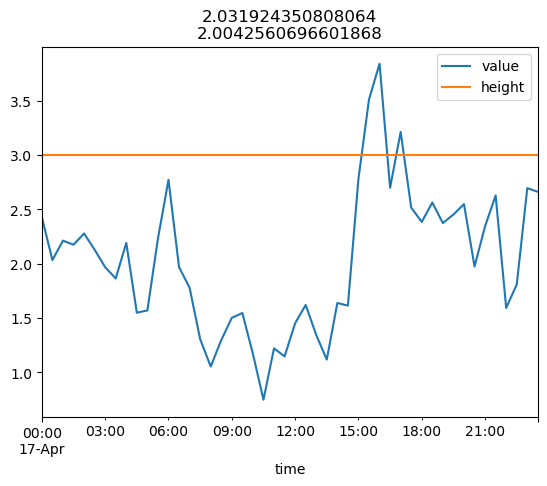

In [4]:
tidy_df.query("variable == 'spd_3m_c'").set_index('time').loc['20230417': '20230417'].plot()
plt.title(
    str(tidy_df.query("variable == 'spd_3m_c'").set_index('time').loc['20230417': '20230417'].value.mean()) + '\n' +
    str(tidy_df.query("variable == 'spd_3m_c'").set_index('time').loc['20230417': '20230417'].value.median())
    )

Text(0.5, 1.0, '2.59585894147555\n2.3447649478912354')

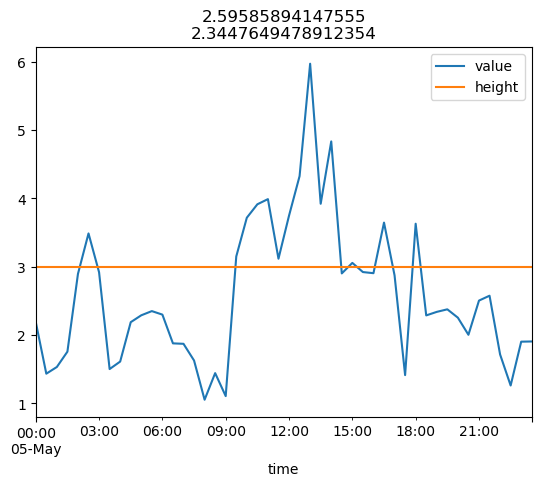

In [5]:
tidy_df.query("variable == 'spd_3m_c'").set_index('time').loc['20230505': '20230505'].plot()
plt.title(
    str(tidy_df.query("variable == 'spd_3m_c'").set_index('time').loc['20230505': '20230505'].value.mean()) + '\n' +
    str(tidy_df.query("variable == 'spd_3m_c'").set_index('time').loc['20230505': '20230505'].value.median())
    )

# Identify categories

In [6]:
# Identify lists of timestamps for different categories
bs_times = set(
    tidy_df.query("variable == 'SF_avg_1m_ue'").query("value > 0").time
).union(
    set(tidy_df.query("variable == 'SF_avg_2m_ue'").query("value > 0").time)
)
nobs_times = set(tidy_df.time).difference(bs_times)

decoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value < 0.43").time
weaklycoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value >= 0.43").query("value <= 0.61").time
coupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value > 0.61").time

ri_stable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value > 0.25").time
ri_unstable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value < -0.01").time
ri_neutral_times = tidy_df.query("variable == 'Ri_3m_c'").query("value >= -0.01").query("value <= 0.25").time

tgrad_stable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value > 0.01").time
tgrad_unstable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value < -0.01").time
tgrad_neutral_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value >= -0.01").query("value <= 0.01").time

In [ ]:
pivot_df = tidy_df[tidy_df.variable.isin([
    'u_h2o__3m_ue', 'v_h2o__3m_ue',
    'u_h2o__10m_ue','v_h2o__10m_ue',
    
    'u_h2o__3m_uw', 'v_h2o__3m_uw',
    'u_h2o__10m_uw','v_h2o__10m_uw',

    'u_h2o__3m_d', 'v_h2o__3m_d',
    'u_h2o__10m_d','v_h2o__10m_d',

    'w_h2o__3m_ue',
    'w_h2o__10m_ue',
    'w_h2o__3m_uw',
    'w_h2o__10m_uw',
    'w_h2o__3m_d',
    'w_h2o__10m_d',
    'w_h2o__3m_c',
    'w_h2o__10m_c',
])][['time', 'variable', 'value']].pivot(index='time', columns='variable', values='value')


In [ ]:
w_h2o__vars = ['w_h2o__1m_ue',
 'w_h2o__2m_ue',
 'w_h2o__2m_d',
 'w_h2o__10m_d',
 'w_h2o__3m_d',
 'w_h2o__10m_uw',
 'w_h2o__3m_uw',
 'w_h2o__10m_ue',
 'w_h2o__3m_ue',
 'w_h2o__15m_c',
 'w_h2o__10m_c',
 'w_h2o__5m_c',
 'w_h2o__3m_c',
 'w_h2o__2m_c',
 'w_h2o__2m_uw',
 'w_h2o__20m_c',
 'w_h2o__2_5m_uw',
 'w_h2o__1m_uw',
 'w_h2o__1m_c',
 'w_h2o__1m_d']

w_tc__vars = ['w_tc__1m_ue',
 'w_tc__2m_ue',
 'w_tc__2m_d',
 'w_tc__10m_d',
 'w_tc__3m_d',
 'w_tc__10m_uw',
 'w_tc__3m_uw',
 'w_tc__10m_ue',
 'w_tc__3m_ue',
 'w_tc__15m_c',
 'w_tc__10m_c',
 'w_tc__5m_c',
 'w_tc__3m_c',
 'w_tc__2m_c',
 'w_tc__2m_uw',
 'w_tc__20m_c',
 'w_tc__2_5m_uw',
 'w_tc__1m_uw',
 'w_tc__1m_c',
 'w_tc__1m_d']

In [ ]:
w_measurements_df = tidy_df[tidy_df.measurement == 'w']
u_measurements_df = tidy_df[tidy_df.measurement == 'u']
v_measurements_df = tidy_df[tidy_df.measurement == 'v']
q_measurements_df = tidy_df[tidy_df.measurement == 'specific humidity']
tke_measurements_df = tidy_df[tidy_df.measurement  == 'turbulent kinetic energy']
w_w__measurements_df = tidy_df[tidy_df.measurement  == 'w_w_']
w_h2o__measurements_df = tidy_df[tidy_df.variable.isin(w_h2o__vars)]
w_tc__measurements_df = tidy_df[tidy_df.variable.isin(w_tc__vars)]
u_h2o__measurements_df = tidy_df[tidy_df.measurement == 'u_h2o_']
v_h2o__measurements_df = tidy_df[tidy_df.measurement == 'v_h2o_']

# Create sub groups of the separate measurements

In [ ]:
def filt_times(df, times):
    return df[df.time.isin(times)]

def get_groups(df):
    return (
        filt_times(df, bs_times),
        filt_times(df, nobs_times),
        filt_times(df, decoupled_times),
        filt_times(df, weaklycoupled_times),
        filt_times(df, coupled_times),
        filt_times(df, ri_stable_times),
        filt_times(df, ri_unstable_times),
        filt_times(df, ri_neutral_times),
        filt_times(df, tgrad_stable_times),
        filt_times(df, tgrad_unstable_times),
        filt_times(df, tgrad_neutral_times)
    )

# <w> measurements - divide into groups
(bs_w_df, nobs_w_df, decoupled_w_df, weaklycoupled_w_df, coupled_w_df, 
ri_stable_w_df, ri_unstable_w_df, ri_neutral_w_df, 
tgrad_stable_w_df, tgrad_unstable_w_df, tgrad_neutral_w_df ) = get_groups(w_measurements_df)

# <u> measurements - divide into groups
(bs_u_df, nobs_u_df, decoupled_u_df, weaklycoupled_u_df, coupled_u_df, 
ri_stable_u_df, ri_unstable_u_df, ri_neutral_u_df, 
tgrad_stable_u_df, tgrad_unstable_u_df, tgrad_neutral_u_df ) = get_groups(u_measurements_df)

# <v> measurements - divide into groups
(bs_v_df, nobs_v_df, decoupled_v_df, weaklycoupled_v_df, coupled_v_df, 
ri_stable_v_df, ri_unstable_v_df, ri_neutral_v_df, 
tgrad_stable_v_df, tgrad_unstable_v_df, tgrad_neutral_v_df ) = get_groups(v_measurements_df)

# <q> measurements - divide into groups
(bs_q_df, nobs_q_df, decoupled_q_df, weaklycoupled_q_df, coupled_q_df, 
ri_stable_q_df, ri_unstable_q_df, ri_neutral_q_df, 
tgrad_stable_q_df, tgrad_unstable_q_df, tgrad_neutral_q_df ) = get_groups(q_measurements_df)

# tke measurements - divide into groups
(bs_tke_df, nobs_tke_df, decoupled_tke_df, weaklycoupled_tke_df, coupled_tke_df, 
ri_stable_tke_df, ri_unstable_tke_df, ri_neutral_tke_df, 
tgrad_stable_tke_df, tgrad_unstable_tke_df, tgrad_neutral_tke_df ) = get_groups(tke_measurements_df)

# <w'w'> measurements - divide into groups
(bs_w_w__df, nobs_w_w__df, decoupled_w_w__df, weaklycoupled_w_w__df, coupled_w_w__df, 
ri_stable_w_w__df, ri_unstable_w_w__df, ri_neutral_w_w__df, 
tgrad_stable_w_w__df, tgrad_unstable_w_w__df, tgrad_neutral_w_w__df ) = get_groups(w_w__measurements_df)

# <w'q'> measurements - divide into groups
(bs_w_h2o_df, nobs_w_h2o_df, decoupled_w_h2o_df, weaklycoupled_w_h2o_df, coupled_w_h2o_df, 
ri_stable_w_h2o_df, ri_unstable_w_h2o_df, ri_neutral_w_h2o_df, 
tgrad_stable_w_h2o_df, tgrad_unstable_w_h2o_df, tgrad_neutral_w_h2o_df ) = get_groups(w_h2o__measurements_df)

# create dfs that have bs/no-bs labels
w_h2o__df_with_bs_indicator = pd.concat([
    filt_times(w_h2o__measurements_df, nobs_times).assign(conditions='No BS'),
    filt_times(w_h2o__measurements_df, bs_times).assign(conditions='BS')
])
w_h2o__tgrad_stable_df_with_bs_indicator = pd.concat([
    filt_times( w_h2o__measurements_df, set(nobs_times).intersection(set(tgrad_stable_times))).assign(conditions='No BS'),
    filt_times( w_h2o__measurements_df, set(bs_times).intersection(set(tgrad_stable_times))).assign(conditions='BS')
])
w_h2o__tgrad_neutral_df_with_bs_indicator = pd.concat([
    filt_times( w_h2o__measurements_df, set(nobs_times).intersection(set(tgrad_neutral_times))).assign(conditions='No BS'),
    filt_times( w_h2o__measurements_df, set(bs_times).intersection(set(tgrad_neutral_times))).assign(conditions='BS')
])
w_h2o__tgrad_unstable_df_with_bs_indicator = pd.concat([
    filt_times( w_h2o__measurements_df, set(nobs_times).intersection(set(tgrad_unstable_times))).assign(conditions='No BS'),
    filt_times( w_h2o__measurements_df, set(bs_times).intersection(set(tgrad_unstable_times))).assign(conditions='BS')
])


# <u'q'> measurements - divide into groups
(bs_u_h2o_df, nobs_u_h2o_df, decoupled_u_h2o_df, weaklycoupled_u_h2o_df, coupled_u_h2o_df, 
ri_stable_u_h2o_df, ri_unstable_u_h2o_df, ri_neutral_u_h2o_df, 
tgrad_stable_u_h2o_df, tgrad_unstable_u_h2o_df, tgrad_neutral_u_h2o_df ) = get_groups(u_h2o__measurements_df)

u_h2o__df_with_bs_indicator = pd.concat([
    filt_times(u_h2o__measurements_df, nobs_times).assign(conditions='No BS'),
    filt_times(u_h2o__measurements_df, bs_times).assign(conditions='BS')
])
u_h2o__tgrad_stable_df_with_bs_indicator = pd.concat([
    filt_times( u_h2o__measurements_df, set(nobs_times).intersection(set(tgrad_stable_times))).assign(conditions='No BS'),
    filt_times( u_h2o__measurements_df, set(bs_times).intersection(set(tgrad_stable_times))).assign(conditions='BS')
])
u_h2o__tgrad_neutral_df_with_bs_indicator = pd.concat([
    filt_times( u_h2o__measurements_df, set(nobs_times).intersection(set(tgrad_neutral_times))).assign(conditions='No BS'),
    filt_times( u_h2o__measurements_df, set(bs_times).intersection(set(tgrad_neutral_times))).assign(conditions='BS')
])
u_h2o__tgrad_unstable_df_with_bs_indicator = pd.concat([
    filt_times( u_h2o__measurements_df, set(nobs_times).intersection(set(tgrad_unstable_times))).assign(conditions='No BS'),
    filt_times( u_h2o__measurements_df, set(bs_times).intersection(set(tgrad_unstable_times))).assign(conditions='BS')
])

# <v'q'> measurements - divide into groups
(bs_v_h2o_df, nobs_v_h2o_df, decoupled_v_h2o_df, weaklycoupled_v_h2o_df, coupled_v_h2o_df, 
ri_stable_v_h2o_df, ri_unstable_v_h2o_df, ri_neutral_v_h2o_df, 
tgrad_stable_v_h2o_df, tgrad_unstable_v_h2o_df, tgrad_neutral_v_h2o_df ) = get_groups(v_h2o__measurements_df)

v_h2o__df_with_bs_indicator = pd.concat([
    filt_times(v_h2o__measurements_df, nobs_times).assign(conditions='No BS'),
    filt_times(v_h2o__measurements_df, bs_times).assign(conditions='BS')
])
v_h2o__tgrad_stable_df_with_bs_indicator = pd.concat([
    filt_times( v_h2o__measurements_df, set(nobs_times).intersection(set(tgrad_stable_times))).assign(conditions='No BS'),
    filt_times( v_h2o__measurements_df, set(bs_times).intersection(set(tgrad_stable_times))).assign(conditions='BS')
])
v_h2o__tgrad_neutral_df_with_bs_indicator = pd.concat([
    filt_times( v_h2o__measurements_df, set(nobs_times).intersection(set(tgrad_neutral_times))).assign(conditions='No BS'),
    filt_times( v_h2o__measurements_df, set(bs_times).intersection(set(tgrad_neutral_times))).assign(conditions='BS')
])
v_h2o__tgrad_unstable_df_with_bs_indicator = pd.concat([
    filt_times( v_h2o__measurements_df, set(nobs_times).intersection(set(tgrad_unstable_times))).assign(conditions='No BS'),
    filt_times( v_h2o__measurements_df, set(bs_times).intersection(set(tgrad_unstable_times))).assign(conditions='BS')
])


# Calculate frequency of lh flux divergence 

Use two different thresholds, 10% and 30%

We compare measurements at 2 measurement heights at a time (2 and 3, and 3 and 5). This is not comprehensive.

In [ ]:
src = w_h2o__measurements_df.pivot(index='time', columns='variable', values='value')
src_w = w_measurements_df.pivot(index='time', columns='variable', values='value')

## Using 2 and 3 meter measurements and 3 and 5 meter measurements

In [ ]:
src['percent diff 2 3'] = (src['w_h2o__3m_c'] - src['w_h2o__2m_c']) / src[['w_h2o__3m_c', 'w_h2o__2m_c']].mean(axis=1)
src['percent diff 3 5'] = (src['w_h2o__5m_c'] - src['w_h2o__3m_c']) / src[['w_h2o__5m_c', 'w_h2o__3m_c']].mean(axis=1)

percent_gt_10_2_3 = len(src[src["percent diff 2 3"] > 0.1])/len(src)
percent_gt_10_3_5 = len(src[src["percent diff 3 5"] > 0.1])/len(src)
percent_gt_30_2_3 = len(src[src["percent diff 2 3"] > 0.3])/len(src)
percent_gt_30_3_5 = len(src[src["percent diff 3 5"] > 0.3])/len(src)

print(f"Using 2 and 3m ECs, LH flux diverges more than 10%, {round(percent_gt_10_2_3*100, 1)}% of the time")
print(f"Using 3 and 5m ECs, LH flux diverges more than 10%, {round(percent_gt_10_3_5*100, 1)}% of the time")
print(f"Using 2 and 3m ECs, LH flux diverges more than 30%, {round(percent_gt_30_2_3*100, 1)}% of the time")
print(f"Using 3 and 5m ECs, LH flux diverges more than 30%, {round(percent_gt_30_3_5*100, 1)}% of the time")

In [ ]:
for name, times in [
    ("bs_times", bs_times,),
    ("nobs_times", nobs_times,),
    ("decoupled_times", decoupled_times,),
    ("weaklycoupled_times", weaklycoupled_times,),
    ("coupled_times", coupled_times,),
    ("ri_stable_times", ri_stable_times,),
    ("ri_unstable_times", ri_unstable_times,),
    ("ri_neutral_times", ri_neutral_times,),
    ("tgrad_stable_times", tgrad_stable_times,),
    ("tgrad_unstable_times", tgrad_unstable_times,),
    ("tgrad_neutral_times", tgrad_neutral_times),
]:
    local_src = src.reset_index()
    local_src = local_src[local_src.time.isin(times)]
    percent_gt_10_2_3 = len(local_src[local_src["percent diff 2 3"] > 0.1])/len(local_src)
    percent_gt_10_3_5 = len(local_src[local_src["percent diff 3 5"] > 0.1])/len(local_src)
    percent_gt_30_2_3 = len(local_src[local_src["percent diff 2 3"] > 0.3])/len(local_src)
    percent_gt_30_3_5 = len(local_src[local_src["percent diff 3 5"] > 0.3])/len(local_src)
    print(name)
    print(f"Using 2 and 3m ECs, LH flux diverges more than 10%, {round(percent_gt_10_2_3*100, 1)}% of the time")
    print(f"Using 3 and 5m ECs, LH flux diverges more than 10%, {round(percent_gt_10_3_5*100, 1)}% of the time")
    print(f"Using 2 and 3m ECs, LH flux diverges more than 30%, {round(percent_gt_30_2_3*100, 1)}% of the time")
    print(f"Using 3 and 5m ECs, LH flux diverges more than 30%, {round(percent_gt_30_3_5*100, 1)}% of the time")
    print()

# Define functions for plotting profiles

In [ ]:
def profile_chart(df, title, x_title):
    return (
        alt.Chart(df).mark_line().encode(
            alt.X("median(value):Q").sort('-y').title(x_title),
            alt.Y("height:Q").scale(zero=True).title("height (m)"),
            alt.Color("tower:N")
        ).properties(title=[title, f"(n = {len(df.time.unique())})"], width=100, height=100)
    )

def lhflux_profile_chart(df, title):
    return (
        alt.Chart(df).transform_aggregate(
            median = "median(value)",
            groupby=['height', 'tower']
        ).transform_calculate(
            low_bound = 'datum.median - 0.2*datum.median',
            up_bound = 'datum.median + 0.2*datum.median'
        ).mark_area(opacity=0.25).encode(
            alt.X("low_bound:Q").title(""),
            alt.X2("up_bound:Q"),
            alt.Y("height:Q").scale(zero=True).title("height (m)"),
            alt.Color("tower:N")
        )
        +
        alt.Chart(df).mark_line().encode(
            alt.X("median(value):Q").sort('-y').title("<w'q'> (g/m^2/s)"),
            alt.Y("height:Q").scale(zero=True).title("height (m)"),
            alt.Color("tower:N")
        ).properties(title=[title, f"(n = {len(df.time.unique())})"], width=150, height=150)
    )

def lhflux_profile_chart_split_conditions(df, title, x_title="<w'q'> (g/m^2/s)", color_encoding=alt.Color(f"conditions:N")):
    n_bs = len(df[df.conditions == 'BS'].time.unique())
    n_nobs = len(df[df.conditions == 'No BS'].time.unique())
    return (
        alt.Chart(df).transform_aggregate(
            median = "median(value)",
            groupby=['height', 'tower', 'conditions']
        ).transform_calculate(
            low_bound = 'datum.median - 0.2*datum.median',
            up_bound = 'datum.median + 0.2*datum.median'
        ).mark_area(opacity=0.25).encode(
            alt.X("low_bound:Q").title(""),
            alt.X2("up_bound:Q"),
            alt.Y("height:Q").scale(zero=True).title('height (m)'),
            color_encoding
        )
        +
        alt.Chart(df).mark_line(point=True).encode(
            alt.X("median(value):Q").sort('-y').title(x_title),
            alt.Y("height:Q").scale(zero=True),
            color_encoding
        ).properties(title=[title, f"(n = {n_bs} BS, {n_nobs} No BS)"], width=150, height=150)
    )

def lhflux_profile_chart_split_conditions_noerror(df, title, x_title="<w'q'> (g/m^2/s)", color_encoding=alt.Color(f"conditions:N")):
    n_bs = len(df[df.conditions == 'BS'].time.unique())
    n_nobs = len(df[df.conditions == 'No BS'].time.unique())
    return alt.Chart(df).mark_line(point=True).encode(
            alt.X("median(value):Q").sort('-y').title(x_title),
            alt.Y("height:Q").scale(zero=True),
            color_encoding
        ).properties(title=[title, f"(n = {n_bs} BS, {n_nobs} No BS)"], width=150, height=150)

def lhflux_profile_chart_notower(df, title, x_title="<w'q'> (g/m^2/s)"):
    return (
        alt.Chart(df).transform_aggregate(
            median = "median(value)",
            groupby=['height', 'tower']
        ).transform_calculate(
            low_bound = 'datum.median - 0.2*datum.median',
            up_bound = 'datum.median + 0.2*datum.median'
        ).mark_area(opacity=0.2, color='black').encode(
            alt.X("low_bound:Q").title(""),
            alt.X2("up_bound:Q"),
            alt.Y("height:Q").scale(zero=True),
        )
        +
        alt.Chart(df).mark_line(point=alt.OverlayMarkDef(color='black'), color='black').encode(
            alt.X("median(value):Q").sort('-y').title(x_title),
            alt.Y("height:Q").scale(zero=True),
        ).properties(title=[title, f"(n = {len(df.time.unique())})"], width=150, height=150)
    )

def lhflux_profile_chart_mg(df, title):
    df.value = df.value*1000
    return (
        alt.Chart(df).transform_aggregate(
            median = "median(value)",
            groupby=['height', 'tower']
        ).transform_calculate(
            low_bound = 'datum.median - 0.2*datum.median',
            up_bound = 'datum.median + 0.2*datum.median'
        ).mark_area(opacity=0.25).encode(
            alt.X("low_bound:Q").title(""),
            alt.X2("up_bound:Q"),
            alt.Y("height:Q").scale(zero=True).title("height (m)"),
            alt.Color("tower:N")
        )
        +
        alt.Chart(df).mark_line(point=True).encode(
            alt.X("median(value):Q").sort('-y').title("<w'q'> (mg/m^2/s)"),
            alt.Y("height:Q").scale(zero=True).title("height (m)"),
            alt.Color("tower:N")
        ).properties(title=[title, f"(n = {len(df.time.unique())})"], width=150, height=150)
    )

def profile_chart(df, title, x_title, color="tower:N"):
    return (
        alt.Chart(df).transform_aggregate(
            median = "median(value)",
            groupby=['height', 'tower']
        ).transform_calculate(
            low_bound = 'datum.median - 0.2*datum.median',
            up_bound = 'datum.median + 0.2*datum.median'
        ).mark_area(opacity=0.25).encode(
            alt.X("low_bound:Q").title(""),
            alt.X2("up_bound:Q"),
            alt.Y("height:Q").scale(zero=True).title("height (m)"),
            alt.Color("tower:N")
        )
        +
        alt.Chart(df).mark_line().encode(
            alt.X("median(value):Q").sort('-y').title(x_title),
            alt.Y("height:Q").scale(zero=True).title("height (m)"),
            alt.Color(color)
        ).properties(title=[title, f"(n = {len(df.time.unique())})"], width=150, height=150)
    )

In [ ]:
tgrad_unstable_df = w_h2o__measurements_df[w_h2o__measurements_df.time.isin(set(tgrad_unstable_times))]
tgrad_stable_df = w_h2o__measurements_df[w_h2o__measurements_df.time.isin(set(tgrad_stable_times))]
tgrad_neutral_df = w_h2o__measurements_df[w_h2o__measurements_df.time.isin(set(tgrad_neutral_times))]

ri_unstable_df = w_h2o__measurements_df[w_h2o__measurements_df.time.isin(set(ri_unstable_times))]
ri_stable_df = w_h2o__measurements_df[w_h2o__measurements_df.time.isin(set(ri_stable_times))]
ri_neutral_df = w_h2o__measurements_df[w_h2o__measurements_df.time.isin(set(ri_neutral_times))]

upvalley_wind_times = tidy_df[tidy_df.variable == 'dir_3m_c'].query("value < 152").query("value > 112").time.values
downvalley_wind_times = tidy_df[tidy_df.variable == 'dir_3m_c'].query("value < 332").query("value > 292").time.values

In [ ]:
ri_stable_df = ri_stable_df.assign(
    conditions = ri_stable_df.time.isin(bs_times).apply(lambda is_bs: 'BS' if is_bs else 'No BS')
)
ri_neutral_df = ri_neutral_df.assign(
    conditions = ri_neutral_df.time.isin(bs_times).apply(lambda is_bs: 'BS' if is_bs else 'No BS')
)
ri_unstable_df = ri_unstable_df.assign(
    conditions = ri_unstable_df.time.isin(bs_times).apply(lambda is_bs: 'BS' if is_bs else 'No BS')
)

vertical_flux_profiles_4_plots = (
    lhflux_profile_chart_notower(w_h2o__measurements_df.query("tower == 'c'").query("height > 1"), "All data") |
    lhflux_profile_chart_split_conditions(ri_stable_df.query("tower == 'c'").query("height > 1"), "Stable") |
    lhflux_profile_chart_split_conditions(ri_neutral_df.query("tower == 'c'").query("height > 1"), "Neutral") |
    lhflux_profile_chart_split_conditions(ri_unstable_df.query("tower == 'c'").query("height > 1"), "Unstable")
).resolve_scale(x='shared', y='shared') 
vertical_flux_profiles_4_plots

In [ ]:
def assign_bs_and_daytime_label(time):
    label = ''
    if time in bs_times:
        label += 'BS'
    else:
        label += 'No BS'
    if time.hour in [10,11,12,13,14,15]:
        label += ', Daytime'
    else:
        label += ', Nighttime'
    if label.startswith('BS'):
        label = 'BS'
    return label
ri_stable_df = ri_stable_df.assign(
    conditions = ri_stable_df.time.apply(assign_bs_and_daytime_label)
)
ri_neutral_df = ri_neutral_df.assign(
    conditions = ri_neutral_df.time.apply(assign_bs_and_daytime_label)
)
ri_unstable_df = ri_unstable_df.assign(
    conditions = ri_unstable_df.time.apply(assign_bs_and_daytime_label)
)

vertical_flux_profiles_4_plots = (
    lhflux_profile_chart_notower(w_h2o__measurements_df.query("tower == 'c'").query("height > 1"), "All data") |
    lhflux_profile_chart_split_conditions(ri_stable_df.query("tower == 'c'").query("height > 1"), "Stable") |
    lhflux_profile_chart_split_conditions(ri_neutral_df.query("tower == 'c'").query("height > 1"), "Neutral") |
    lhflux_profile_chart_split_conditions(ri_unstable_df.query("tower == 'c'").query("height > 1"), "Unstable")
).resolve_scale(x='shared', y='shared') 
vertical_flux_profiles_4_plots

In [ ]:
vertical_flux_profiles_4_plots.save('lhflux_profiles.png', dpi=200)

In [ ]:

tc_ri_unstable_df = w_tc__measurements_df[w_tc__measurements_df.time.isin(set(ri_unstable_times))]
tc_ri_stable_df = w_tc__measurements_df[w_tc__measurements_df.time.isin(set(ri_stable_times))]
tc_ri_neutral_df = w_tc__measurements_df[w_tc__measurements_df.time.isin(set(ri_neutral_times))]

tc_ri_stable_df = tc_ri_stable_df.assign(
    conditions = tc_ri_stable_df.time.apply(assign_bs_and_daytime_label)
)
tc_ri_neutral_df = tc_ri_neutral_df.assign(
    conditions = tc_ri_neutral_df.time.apply(assign_bs_and_daytime_label)
)
tc_ri_unstable_df = tc_ri_unstable_df.assign(
    conditions = tc_ri_unstable_df.time.apply(assign_bs_and_daytime_label)
)

(
    lhflux_profile_chart_notower(w_h2o__measurements_df.query("tower == 'c'").query("height > 1"), "All data") |
    lhflux_profile_chart_split_conditions(tc_ri_stable_df.query("tower == 'c'").query("height > 1").query("conditions != 'BS'"), "Stable") |
    lhflux_profile_chart_split_conditions(tc_ri_neutral_df.query("tower == 'c'").query("height > 1").query("conditions != 'BS'"), "Neutral") |
    lhflux_profile_chart_split_conditions(tc_ri_unstable_df.query("tower == 'c'").query("height > 1").query("conditions != 'BS'"), "Unstable")
).resolve_scale(x='shared', y='shared') 

In [ ]:

w_ri_unstable_df = w_w__measurements_df[w_w__measurements_df.time.isin(set(ri_unstable_times))]
w_ri_stable_df = w_w__measurements_df[w_w__measurements_df.time.isin(set(ri_stable_times))]
w_ri_neutral_df = w_w__measurements_df[w_w__measurements_df.time.isin(set(ri_neutral_times))]

w_ri_stable_df = w_ri_stable_df.assign(
    conditions = w_ri_stable_df.time.apply(assign_bs_and_daytime_label)
)
w_ri_neutral_df = w_ri_neutral_df.assign(
    conditions = w_ri_neutral_df.time.apply(assign_bs_and_daytime_label)
)
w_ri_unstable_df = w_ri_unstable_df.assign(
    conditions = w_ri_unstable_df.time.apply(assign_bs_and_daytime_label)
)

(
    lhflux_profile_chart_notower(w_h2o__measurements_df.query("tower == 'c'").query("height > 1"), "All data") |
    lhflux_profile_chart_split_conditions(w_ri_stable_df.query("tower == 'c'").query("height > 1").query("conditions != 'BS'"), "Stable") |
    lhflux_profile_chart_split_conditions(w_ri_neutral_df.query("tower == 'c'").query("height > 1").query("conditions != 'BS'"), "Neutral") |
    lhflux_profile_chart_split_conditions(w_ri_unstable_df.query("tower == 'c'").query("height > 1").query("conditions != 'BS'"), "Unstable")
).resolve_scale(x='shared', y='shared') 

In [ ]:
ri_stable_df = ri_stable_df.assign(
    conditions = ri_stable_df.time.isin(bs_times).apply(lambda is_bs: 'BS' if is_bs else 'No BS')
)
ri_neutral_df = ri_neutral_df.assign(
    conditions = ri_neutral_df.time.isin(bs_times).apply(lambda is_bs: 'BS' if is_bs else 'No BS')
)
ri_unstable_df = ri_unstable_df.assign(
    conditions = ri_unstable_df.time.isin(bs_times).apply(lambda is_bs: 'BS' if is_bs else 'No BS')
)

vertical_flux_profiles_4_plots = (
    lhflux_profile_chart_notower(w_h2o__measurements_df[w_h2o__measurements_df.time.isin(nobs_times)][w_h2o__measurements_df.time.dt.hour.isin(
        [10,11,12,13,14,15])].query("tower == 'c'").query("height > 1"), "All data") |
    lhflux_profile_chart_split_conditions(ri_stable_df[ri_stable_df.conditions=='No BS'][ri_stable_df.time.dt.hour.isin(
        [10,11,12,13,14,15])].query("tower == 'c'").query("height > 1"), "Stable") |
    lhflux_profile_chart_split_conditions(ri_neutral_df[ri_neutral_df.conditions=='No BS'][ri_neutral_df.time.dt.hour.isin(
        [10,11,12,13,14,15])].query("tower == 'c'").query("height > 1"), "Neutral") |
    lhflux_profile_chart_split_conditions(ri_unstable_df[ri_unstable_df.conditions=='No BS'][ri_unstable_df.time.dt.hour.isin(
        [10,11,12,13,14,15])].query("tower == 'c'").query("height > 1"), "Unstable")
).resolve_scale(x='shared', y='shared') 
vertical_flux_profiles_4_plots

In [ ]:
(
    lhflux_profile_chart_notower(w_h2o__measurements_df[w_h2o__measurements_df.time.isin(nobs_times)][
        w_h2o__measurements_df.time.isin(downvalley_wind_times)
    ].query("tower == 'c'").query("height > 1"), "All data") 
    |
    lhflux_profile_chart_split_conditions(ri_stable_df[ri_stable_df.conditions=='No BS'][
        ri_stable_df.time.isin(downvalley_wind_times)
    ].query("tower == 'c'").query("height > 1"), "Stable") 
    |
    lhflux_profile_chart_split_conditions(ri_neutral_df[ri_neutral_df.conditions=='No BS'][
        ri_neutral_df.time.isin(downvalley_wind_times)
    ].query("tower == 'c'").query("height > 1"), "Neutral") 
    |
    lhflux_profile_chart_split_conditions(ri_unstable_df[ri_unstable_df.conditions=='No BS'][
        ri_unstable_df.time.isin(downvalley_wind_times)
    ].query("tower == 'c'").query("height > 1"), "Unstable")
).resolve_scale(x='shared', y='shared').properties(title='Downvalley wind times') &\
(
    lhflux_profile_chart_notower(w_h2o__measurements_df[w_h2o__measurements_df.time.isin(nobs_times)][
        w_h2o__measurements_df.time.isin(upvalley_wind_times)
    ].query("tower == 'c'").query("height > 1"), "All data") 
    |
    lhflux_profile_chart_split_conditions(ri_stable_df[ri_stable_df.conditions=='No BS'][
        ri_stable_df.time.isin(upvalley_wind_times)
    ].query("tower == 'c'").query("height > 1"), "Stable") 
    |
    lhflux_profile_chart_split_conditions(ri_neutral_df[ri_neutral_df.conditions=='No BS'][
        ri_neutral_df.time.isin(upvalley_wind_times)
    ].query("tower == 'c'").query("height > 1"), "Neutral") 
    |
    lhflux_profile_chart_split_conditions(ri_unstable_df[ri_unstable_df.conditions=='No BS'][
        ri_unstable_df.time.isin(upvalley_wind_times)
    ].query("tower == 'c'").query("height > 1"), "Unstable")
).resolve_scale(x='shared', y='shared').properties(title='Upvalley wind times')

only daytime hours

In [ ]:
(
    lhflux_profile_chart_notower(w_h2o__measurements_df[w_h2o__measurements_df.time.dt.hour.isin([10,11,12,13,14,15,16])][w_h2o__measurements_df.time.isin(nobs_times)][
        w_h2o__measurements_df.time.isin(downvalley_wind_times)
    ].query("tower == 'c'").query("height > 1"), "All data") 
    |
    lhflux_profile_chart_split_conditions(ri_stable_df[ri_stable_df.time.dt.hour.isin([10,11,12,13,14,15,16])][ri_stable_df.conditions=='No BS'][
        ri_stable_df.time.isin(downvalley_wind_times)
    ].query("tower == 'c'").query("height > 1"), "Stable") 
    |
    lhflux_profile_chart_split_conditions(ri_neutral_df[ri_neutral_df.time.dt.hour.isin([10,11,12,13,14,15,16])][ri_neutral_df.conditions=='No BS'][
        ri_neutral_df.time.isin(downvalley_wind_times)
    ].query("tower == 'c'").query("height > 1"), "Neutral") 
    |
    lhflux_profile_chart_split_conditions(ri_unstable_df[ri_unstable_df.time.dt.hour.isin([10,11,12,13,14,15,16])][ri_unstable_df.conditions=='No BS'][
        ri_unstable_df.time.isin(downvalley_wind_times)
    ].query("tower == 'c'").query("height > 1"), "Unstable")
).resolve_scale(x='shared', y='shared').properties(title='Downvalley wind times') &\
(
    lhflux_profile_chart_notower(w_h2o__measurements_df[w_h2o__measurements_df.time.dt.hour.isin([10,11,12,13,14,15,16])][w_h2o__measurements_df.time.isin(nobs_times)][
        w_h2o__measurements_df.time.isin(upvalley_wind_times)
    ].query("tower == 'c'").query("height > 1"), "All data") 
    |
    lhflux_profile_chart_split_conditions(ri_stable_df[ri_stable_df.time.dt.hour.isin([10,11,12,13,14,15,16])][ri_stable_df.conditions=='No BS'][
        ri_stable_df.time.isin(upvalley_wind_times)
    ].query("tower == 'c'").query("height > 1"), "Stable") 
    |
    lhflux_profile_chart_split_conditions(ri_neutral_df[ri_neutral_df.time.dt.hour.isin([10,11,12,13,14,15,16])][ri_neutral_df.conditions=='No BS'][
        ri_neutral_df.time.isin(upvalley_wind_times)
    ].query("tower == 'c'").query("height > 1"), "Neutral") 
    |
    lhflux_profile_chart_split_conditions(ri_unstable_df[ri_unstable_df.time.dt.hour.isin([10,11,12,13,14,15,16])][ri_unstable_df.conditions=='No BS'][
        ri_unstable_df.time.isin(upvalley_wind_times)
    ].query("tower == 'c'").query("height > 1"), "Unstable")
).resolve_scale(x='shared', y='shared').properties(title='Upvalley wind times')

In [ ]:
w_measurements_df
w_ri_stable_df = w_measurements_df[w_measurements_df.time.isin(tgrad_stable_times)]
w_ri_stable_df = w_ri_stable_df.assign(
    conditions = w_ri_stable_df.time.isin(bs_times).apply(lambda is_bs: 'BS' if is_bs else 'No BS')
)
w_ri_nuetral_df = w_measurements_df[w_measurements_df.time.isin(tgrad_neutral_times)]
w_ri_nuetral_df = w_ri_nuetral_df.assign(
    conditions = w_ri_nuetral_df.time.isin(bs_times).apply(lambda is_bs: 'BS' if is_bs else 'No BS')
)
w_ri_unstable_df = w_measurements_df[w_measurements_df.time.isin(tgrad_unstable_times)]
w_ri_unstable_df = w_ri_unstable_df.assign(
    conditions = w_ri_unstable_df.time.isin(bs_times).apply(lambda is_bs: 'BS' if is_bs else 'No BS')
)

In [ ]:
(
    lhflux_profile_chart_notower(w_measurements_df[w_measurements_df.time.dt.hour.isin([10,11,12,13,14,15,16])][w_measurements_df.time.isin(nobs_times)][
        w_measurements_df.time.isin(downvalley_wind_times)
    ].query("tower == 'c'").query("height > 1"), "All data") 
    |
    lhflux_profile_chart_split_conditions(w_ri_stable_df[w_ri_stable_df.time.dt.hour.isin([10,11,12,13,14,15,16])][w_ri_stable_df.conditions=='No BS'][
        w_ri_stable_df.time.isin(downvalley_wind_times)
    ].query("tower == 'c'").query("height > 1"), "Stable") 
    |
    lhflux_profile_chart_split_conditions(w_ri_nuetral_df[w_ri_nuetral_df.time.dt.hour.isin([10,11,12,13,14,15,16])][w_ri_nuetral_df.conditions=='No BS'][
        w_ri_nuetral_df.time.isin(downvalley_wind_times)
    ].query("tower == 'c'").query("height > 1"), "Neutral") 
    |
    lhflux_profile_chart_split_conditions(w_ri_unstable_df[w_ri_unstable_df.time.dt.hour.isin([10,11,12,13,14,15,16])][w_ri_unstable_df.conditions=='No BS'][
        w_ri_unstable_df.time.isin(downvalley_wind_times)
    ].query("tower == 'c'").query("height > 1"), "Unstable")
).resolve_scale(x='shared', y='shared').properties(title='Downvalley wind times') &\
(
    lhflux_profile_chart_notower(w_measurements_df[w_measurements_df.time.dt.hour.isin([10,11,12,13,14,15,16])][w_measurements_df.time.isin(nobs_times)][
        w_measurements_df.time.isin(upvalley_wind_times)
    ].query("tower == 'c'").query("height > 1"), "All data") 
    |
    lhflux_profile_chart_split_conditions(w_ri_stable_df[w_ri_stable_df.time.dt.hour.isin([10,11,12,13,14,15,16])][w_ri_stable_df.conditions=='No BS'][
        w_ri_stable_df.time.isin(upvalley_wind_times)
    ].query("tower == 'c'").query("height > 1"), "Stable") 
    |
    lhflux_profile_chart_split_conditions(w_ri_nuetral_df[w_ri_nuetral_df.time.dt.hour.isin([10,11,12,13,14,15,16])][w_ri_nuetral_df.conditions=='No BS'][
        w_ri_nuetral_df.time.isin(upvalley_wind_times)
    ].query("tower == 'c'").query("height > 1"), "Neutral") 
    |
    lhflux_profile_chart_split_conditions(w_ri_unstable_df[w_ri_unstable_df.time.dt.hour.isin([10,11,12,13,14,15,16])][w_ri_unstable_df.conditions=='No BS'][
        w_ri_unstable_df.time.isin(upvalley_wind_times)
    ].query("tower == 'c'").query("height > 1"), "Unstable")
).resolve_scale(x='shared', y='shared').properties(title='Upvalley wind times')

In [ ]:
w_measurements_df

In [ ]:
for T in [-20, -10, 0, 5]:
    print(f"T: {T}")
    for rh in [50.0, 50-1.5, 50+1.5]:
        s = 1000*calc.mixing_ratio_from_relative_humidity(
            0.7   *   units.units('atm'),
            T  *   units.units('degC'),
            rh  *   units.units('percent')
        )
        print(f"RH: {rh}%,\ts: {round(s,2)}, σ: ± ")

In [ ]:
src = tidy_df[tidy_df.measurement == 'mixing ratio'].query("tower == 'c'")
src = src[src.time.isin(nobs_times)]
src = src[src.time.isin(upvalley_wind_times)]
src['conditions'] = src.time.dt.hour
src = src[src.conditions % 2 == 0]
(alt.Chart(src[src.conditions < 12]).transform_filter(
    alt.datum.height > 0
).mark_line().encode(
    alt.X('mean(value):Q').scale(zero=False),
    alt.Y('height:Q'),
    alt.Color('hours(time):N')
).properties(width=150, height=150) | alt.Chart(src[src.conditions > 12]).transform_filter(
    alt.datum.height > 0
).mark_line().encode(
    alt.X('mean(value):Q').scale(zero=False),
    alt.Y('height:Q'),
    alt.Color('hours(time):N')
).properties(width=150, height=150)).resolve_scale(color='independent').display(renderer='svg')

In [ ]:
src = tidy_df[tidy_df.measurement == 'mixing ratio'].query("tower == 'c'")
src = src[src.time.isin(nobs_times)]
src['conditions'] = src.time.dt.hour
src = src[src.conditions % 2 == 0]
src_downvalley = src[src.time.isin(downvalley_wind_times)]
src_upvalley = src[src.time.isin(upvalley_wind_times)]
def plot(src):
    return (alt.Chart(src[src.conditions < 12]).transform_filter(
        alt.datum.height > 0
    ).mark_line().encode(
        alt.X('mean(value):Q').scale(zero=False).title('Mixing ratio (g/g)'),
        alt.Y('height:Q'),
        alt.Color('hours(time):N')
    ).properties(width=150, height=150) | alt.Chart(src[src.conditions > 12]).transform_filter(
        alt.datum.height > 0
    ).mark_line().encode(
        alt.X('mean(value):Q').scale(zero=False).title('Mixing ratio (g/g)'),
        alt.Y('height:Q'),
        alt.Color('hours(time):N')
    ).properties(width=150, height=150)).resolve_scale(x='shared', color='independent')
(plot(src_downvalley).properties(title='Downvalley winds') & plot(src_upvalley).properties(title='Upvalley winds') & plot(src).properties(title='Neither')).resolve_scale(
    x='shared', 
    # color='shared'
) 

In [ ]:
src = tidy_df[tidy_df.measurement == 'mixing ratio'].query("tower == 'c'")
src = src[src.time.isin(nobs_times)]
src['conditions'] = src.time.dt.hour
# src = src[src.conditions % 4 == 0]
src['conditions'] = pd.cut(
    src.time.dt.hour,
    [-1,3,7,11,15,19,23],
    labels=['0-3','4-7','8-11','12-15','16-19','20-23']
)
src['value'] = src['value']*1000
src_downvalley = src[src.time.isin(downvalley_wind_times)]
src_upvalley = src[src.time.isin(upvalley_wind_times)]

def plot(src):
    return alt.Chart(src).transform_filter(
        alt.datum.height > 0
    ).transform_filter(
        alt.datum.height != 12
    ).transform_filter(
        alt.datum.height != 6
    ).mark_line(point={'size':20}, strokeWidth=1).encode(
        alt.X('mean(value):Q').scale(zero=False).title('Mixing ratio (g/Kg)'),
        alt.Y('height:Q').title('Height (m)'),
        alt.Color('conditions:N', sort=['0-3','4-7','8-11','12-15','16-19','20-23']).title(
            'time (hours)'
        )
    ).properties(width=150, height=150)
(
    plot(src_upvalley).properties(title='Upvalley winds') | 
    plot(src_downvalley).properties(title='Downvalley winds')
).resolve_scale(
    x='shared', 
    # color='shared'
).configure_legend(orient='left').display(renderer='svg')

In [ ]:
rule = alt.Chart().transform_calculate(rule='0').mark_rule().encode(x='rule:Q')

In [ ]:
src = tidy_df[tidy_df.measurement == 'w'].query("tower == 'c'").query("height >= 3")
src = src[src.time.isin(nobs_times)]
src['conditions'] = src.time.dt.hour
src = src[src.conditions % 2 == 0]
src_downvalley = src[src.time.isin(downvalley_wind_times)]
src_upvalley = src[src.time.isin(upvalley_wind_times)]
def plot(src):
    return (alt.Chart(src[src.conditions < 12]).transform_filter(
        alt.datum.height > 0
    ).mark_line().encode(
        alt.X('median(value):Q').scale(zero=False).title('w (m/s)'),
        alt.Y('height:Q'),
        alt.Color('hours(time):N')
    ).properties(width=150, height=150) + rule | rule+alt.Chart(src[src.conditions > 12]).transform_filter(
        alt.datum.height > 0
    ).mark_line().encode(
        alt.X('median(value):Q').scale(zero=False).title('w (m/s)'),
        alt.Y('height:Q'),
        alt.Color('hours(time):N')
    ).properties(width=150, height=150)).resolve_scale(x='shared', color='independent')
(plot(src_downvalley).properties(title='Downvalley winds') & plot(src_upvalley).properties(title='Upvalley winds') & plot(src).properties(title='Neither')).resolve_scale(
    x='shared', 
    # color='shared'
) 

In [ ]:
src = w_h2o__measurements_df.query("tower == 'c'").query("height >= 3")
src = src[src.time.isin(nobs_times)]
src['conditions'] = src.time.dt.hour
src = src[src.conditions % 2 == 0]
src_downvalley = src[src.time.isin(downvalley_wind_times)]
src_upvalley = src[src.time.isin(upvalley_wind_times)]
def plot(src):
    return (alt.Chart(src[src.conditions < 12]).transform_filter(
        alt.datum.height > 0
    ).mark_line().encode(
        alt.X('median(value):Q').scale(zero=False).title("w'q' (g/m^2/s)"),
        alt.Y('height:Q'),
        alt.Color('hours(time):N')
    ).properties(width=150, height=150) + rule | rule+alt.Chart(src[src.conditions > 12]).transform_filter(
        alt.datum.height > 0
    ).mark_line().encode(
        alt.X('median(value):Q').scale(zero=False).title("w'q' (g/m^2/s)"),
        alt.Y('height:Q'),
        alt.Color('hours(time):N')
    ).properties(width=150, height=150)).resolve_scale(x='shared', color='independent')
(plot(src_downvalley).properties(title='downvalley') & plot(src_upvalley).properties(title='upvalley') & plot(src).properties(title='Neither')).resolve_scale(
    x='shared', 
    # color='shared'
) 

In [ ]:
src = w_h2o__measurements_df.copy()
src = src[src.time.isin(nobs_times)]
src['conditions'] = src.time.dt.hour
src = src[src.conditions % 4 == 0]
src = src.query("tower == 'c'").query("height > 1")
def by_hour_dual_plot(src):
    return (
        lhflux_profile_chart_split_conditions(src," ").properties(title=' ', width=100, height=100)
    )
(by_hour_dual_plot(src = src[src.time.dt.month == 12]).properties(title='December') |\
by_hour_dual_plot(src = src[src.time.dt.month == 1]).properties(title='January') |\
by_hour_dual_plot(src = src[src.time.dt.month == 2]).properties(title='February') |\
by_hour_dual_plot(src = src[src.time.dt.month == 3]).properties(title='March') |\
by_hour_dual_plot(src = src[src.time.dt.month == 4]).properties(title='April') |\
by_hour_dual_plot(src = src[src.time.dt.month == 5]).properties(title='May')
).display(renderer='svg')

In [ ]:
by_hour_dual_plot(src = src[src.time.dt.strftime('%Y%m%d') == '20230505'])

In [ ]:
src = w_h2o__measurements_df.copy()
src = src[src.time.isin(nobs_times)]
src['conditions'] = src.time.dt.hour
src = src[src.conditions % 3 == 0]
src = src.query("tower == 'c'").query("height > 1")
(
    lhflux_profile_chart_split_conditions(
        src[src.time.dt.strftime('%Y%m%d') == '20230417']," "
    ).properties(title='20230417', width=200, height=200)
    |\
    lhflux_profile_chart_split_conditions(
        src[src.time.dt.strftime('%Y%m%d') == '20230505']," "
    ).properties(title='20230505', width=200, height=200)
).display(renderer='svg')

In [ ]:
src = u_h2o__measurements_df.copy()
src = src[src.time.isin(nobs_times)]
src['conditions'] = src.time.dt.hour
src = src[src.conditions % 2 == 0]
src = src.query("tower == 'c'").query("height > 1")
(
lhflux_profile_chart_split_conditions(src[src.conditions < 12],"All data") |\
lhflux_profile_chart_split_conditions(src[src.conditions >= 12],"All data")
).resolve_scale(color='independent', x='shared')

In [ ]:
src = v_h2o__measurements_df.copy()
src = src[src.time.isin(nobs_times)]
src['conditions'] = src.time.dt.hour
src = src[src.conditions % 2 == 0]
src = src.query("tower == 'c'").query("height > 1")
(
lhflux_profile_chart_split_conditions(src[src.conditions < 12],"All data") |\
lhflux_profile_chart_split_conditions(src[src.conditions >= 12],"All data")
).resolve_scale(color='independent', x='shared')

In [ ]:
def vertical_flux_profiles_4_plots_for_month(months):
    return (
        lhflux_profile_chart_notower(w_h2o__measurements_df[
            w_h2o__measurements_df.time.dt.month.isin(months)
        ].query("tower == 'c'").query("height > 1"), "All data") |
        lhflux_profile_chart_split_conditions(ri_stable_df[
            ri_stable_df.time.dt.month.isin(months)
        ].query("tower == 'c'").query("height > 1"), "Stable") |
        lhflux_profile_chart_split_conditions(ri_neutral_df[
            ri_neutral_df.time.dt.month.isin(months)
        ].query("tower == 'c'").query("height > 1"), "Neutral") |
        lhflux_profile_chart_split_conditions(ri_unstable_df[
            ri_unstable_df.time.dt.month.isin(months)
        ].query("tower == 'c'").query("height > 1"), "Unstable")
    ).resolve_scale(x='shared', y='shared') 
vertical_flux_profiles_4_plots_for_month([12]) &\
vertical_flux_profiles_4_plots_for_month([1]) &\
vertical_flux_profiles_4_plots_for_month([2]) &\
vertical_flux_profiles_4_plots_for_month([3]) &\
vertical_flux_profiles_4_plots_for_month([4]) &\
vertical_flux_profiles_4_plots_for_month([5])
    

In [ ]:
tgrad_stable_df['conditions'] = tgrad_stable_df.time.isin(bs_times).apply(lambda is_bs: 'BS' if is_bs else 'No BS')
tgrad_neutral_df['conditions'] = tgrad_neutral_df.time.isin(bs_times).apply(lambda is_bs: 'BS' if is_bs else 'No BS')
tgrad_unstable_df['conditions'] = tgrad_unstable_df.time.isin(bs_times).apply(lambda is_bs: 'BS' if is_bs else 'No BS')

vertical_flux_profiles_4_plots = (
    lhflux_profile_chart_notower(w_h2o__measurements_df.query("tower == 'c'").query("height > 1"), "All data") |
    lhflux_profile_chart_split_conditions(tgrad_stable_df.query("tower == 'c'").query("height > 1"), "Stable") |
    lhflux_profile_chart_split_conditions(tgrad_neutral_df.query("tower == 'c'").query("height > 1"), "Neutral") |
    lhflux_profile_chart_split_conditions(tgrad_unstable_df.query("tower == 'c'").query("height > 1"), "Unstable")
).resolve_scale(x='shared', y='shared') 
vertical_flux_profiles_4_plots

In [ ]:
src = w_h2o__measurements_df[w_h2o__measurements_df.variable.isin([
    'w_h2o__2m_c', 'w_h2o__3m_c', 'w_h2o__5m_c', 'w_h2o__10m_c', 'w_h2o__15m_c', 'w_h2o__20m_c',
    'w_h2o__3m_ue', 'w_h2o__10m_ue',
    'w_h2o__3m_d', 'w_h2o__10m_d',
    'w_h2o__3m_uw', 'w_h2o__10m_uw',
])]
src = src[~src.time.isin(bs_times)]
(
    alt.Chart(src).mark_line().encode(
        alt.X('hours(time):T'),
        alt.Y('median(value):Q').scale(domain=[-0.006,0.006], clamp=True),
        alt.Color('height:O').scale(scheme='sinebow'),
        alt.Facet('tower:N')
    ).properties(width = 150, height = 150, title='all data') &\
    alt.Chart(src[src.time.isin(set(tgrad_stable_times))]).mark_line().encode(
        alt.X('hours(time):T'),
        alt.Y('median(value):Q'),
        alt.Color('height:O').scale(scheme='sinebow'),
        alt.Facet('tower:N')
    ).properties(width = 150, height = 150, title='stable') &\
    alt.Chart(src[src.time.isin(set(tgrad_neutral_times))]).mark_line().encode(
        alt.X('hours(time):T'),
        alt.Y('median(value):Q'),
        alt.Color('height:O').scale(scheme='sinebow'),
        alt.Facet('tower:N')
    ).properties(width = 150, height = 150, title='neutral') &\
    alt.Chart(src[src.time.isin(set(tgrad_unstable_times))]).mark_line().encode(
        alt.X('hours(time):T'),
        alt.Y('median(value):Q'),
        alt.Color('height:O').scale(scheme='sinebow'),
        alt.Facet('tower:N')
    ).properties(width = 150, height = 150, title='unstable')
).resolve_scale(y='shared', x='shared')

In [ ]:
tgrad_stable_df_day = tgrad_stable_df[tgrad_stable_df.time.dt.hour.isin([9,10,11,12,13,14,15,16,17])]
tgrad_neutral_df_day = tgrad_neutral_df[tgrad_neutral_df.time.dt.hour.isin([9,10,11,12,13,14,15,16,17])]
tgrad_unstable_df_day = tgrad_unstable_df[tgrad_unstable_df.time.dt.hour.isin([9,10,11,12,13,14,15,16,17])]

tgrad_stable_df_night = tgrad_stable_df[tgrad_stable_df.time.dt.hour.isin([19,20,21,21,23,0,1,2,3,4,5,6])]
tgrad_neutral_df_night = tgrad_neutral_df[tgrad_neutral_df.time.dt.hour.isin([19,20,21,21,23,0,1,2,3,4,5,6])]
tgrad_unstable_df_night = tgrad_unstable_df[tgrad_unstable_df.time.dt.hour.isin([19,20,21,21,23,0,1,2,3,4,5,6])]

vertical_flux_profiles_4_plots_day = (
    lhflux_profile_chart_notower(
        w_h2o__measurements_df[
            w_h2o__measurements_df.time.dt.hour.isin([9,10,11,12,13,14,15,16,17])
        ].query("tower == 'c'").query("height > 1"), "All data (Daytime)") |
    lhflux_profile_chart_split_conditions(tgrad_stable_df_day.query("tower == 'c'").query("height > 1"), "Stable (Daytime)") |
    lhflux_profile_chart_split_conditions(tgrad_neutral_df_day.query("tower == 'c'").query("height > 1"), "Neutral (Daytime)") |
    lhflux_profile_chart_split_conditions(tgrad_unstable_df_day.query("tower == 'c'").query("height > 1"), "Unstable (Daytime)")
).resolve_scale(x='shared', y='shared') 

vertical_flux_profiles_4_plots_night = (
    lhflux_profile_chart_notower(
        w_h2o__measurements_df[
            w_h2o__measurements_df.time.dt.hour.isin([19,20,21,21,23,0,1,2,3,4,5,6])
        ].query("tower == 'c'").query("height > 1"), "All data (Nighttime)") |
    lhflux_profile_chart_split_conditions(tgrad_stable_df_night.query("tower == 'c'").query("height > 1"), "Stable (Nighttime)") |
    lhflux_profile_chart_split_conditions(tgrad_neutral_df_night.query("tower == 'c'").query("height > 1"), "Neutral (Nighttime)")
    # lhflux_profile_chart_split_conditions(tgrad_unstable_df_night.query("tower == 'c'").query("height > 1"), "Unstable (Nighttime)")
).resolve_scale(x='shared', y='shared') 
(
    vertical_flux_profiles_4_plots_day &
    vertical_flux_profiles_4_plots_night
)#.resolve_scale(x='shared', y='shared') 

# Create streamwise dataset

In [ ]:
tidy_df_streamwise = tidy_df.swifter.groupby('time').apply(extrautils.streamwise_coordinates_single_rotation_tidy_df)
tidy_df_streamwise = tidy_df_streamwise.reset_index(drop=True)

# tidy_df_streamwise = extrautils.streamwise_coordinates_single_rotation_tidy_df(tidy_df)

In [ ]:
alt.Chart(tidy_df[tidy_df.variable.isin(['u_3m_c', 'v_3m_c'])].query("time < '20221215'")).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("variable")
).properties(width=600) &\
alt.Chart(tidy_df_streamwise[tidy_df_streamwise.variable.isin(['u_3m_c', 'v_3m_c'])].query("time < '20221215'")).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("variable")
).properties(width=600)

# Plot vertical profiles using the basic categories (stability and BS)

In [ ]:
combo_mean_w_profile_chart = (
        profile_chart(w_measurements_df.query("height > 1"), "All data", '<w> (m/s)') | 
        profile_chart(bs_w_df.query("height > 1"), "BS", '<w> (m/s)') | 
        profile_chart(nobs_w_df.query("height > 1"), "No BS", '<w> (m/s)') |         
        profile_chart(tgrad_stable_w_df.query("height > 1"), "Tgrad stable", '<w> (m/s)') | 
        profile_chart(tgrad_neutral_w_df.query("height > 1"), "Tgrad Neutral", '<w> (m/s)') | 
        profile_chart(tgrad_unstable_w_df.query("height > 1"), "Tgrad Unstable", '<w> (m/s)') #| 
).resolve_scale(x='shared', y='shared')

combo_mean_u_profile_chart = (
        profile_chart(u_measurements_df.query("height > 1"), "All data", '<u> (m/s)') | 
        profile_chart(bs_u_df.query("height > 1"), "BS", '<u> (m/s)') | 
        profile_chart(nobs_u_df.query("height > 1"), "No BS", '<u> (m/s)') |         
        profile_chart(tgrad_stable_u_df.query("height > 1"), "Tgrad stable", '<u> (m/s)') | 
        profile_chart(tgrad_neutral_u_df.query("height > 1"), "Tgrad Neutral", '<u> (m/s)') | 
        profile_chart(tgrad_unstable_u_df.query("height > 1"), "Tgrad Unstable", '<u> (m/s)') #| 
).resolve_scale(x='shared', y='shared')

combo_mean_v_profile_chart = ( 
        profile_chart(v_measurements_df.query("height > 1"), "All data", '<v> (m/s)') | 
        profile_chart(bs_v_df.query("height > 1"), "BS", '<v> (m/s)') | 
        profile_chart(nobs_v_df.query("height > 1"), "No BS", '<v> (m/s)') |         
        profile_chart(tgrad_stable_v_df.query("height > 1"), "Tgrad stable", '<v> (m/s)') | 
        profile_chart(tgrad_neutral_v_df.query("height > 1"), "Tgrad Neutral", '<v> (m/s)') | 
        profile_chart(tgrad_unstable_v_df.query("height > 1"), "Tgrad Unstable", '<v> (m/s)') #| 
).resolve_scale(x='shared', y='shared')

combo_mean_tke_profile_chart = (
        profile_chart(tke_measurements_df.query("height > 1"), "All data", 'tke (m^2/s^2)') | 
        profile_chart(bs_tke_df.query("height > 1"), "BS", 'tke (m^2/s^2)') | 
        profile_chart(nobs_tke_df.query("height > 1"), "No BS", 'tke (m^2/s^2)') |         
        profile_chart(tgrad_stable_tke_df.query("height > 1"), "Tgrad stable", 'tke (m^2/s^2)') | 
        profile_chart(tgrad_neutral_tke_df.query("height > 1"), "Tgrad Neutral", 'tke (m^2/s^2)') | 
        profile_chart(tgrad_unstable_tke_df.query("height > 1"), "Tgrad Unstable", 'tke (m^2/s^2)') #| 
).resolve_scale(x='shared', y='shared')

combo_mean_w_w__profile_chart = (
        profile_chart(w_w__measurements_df.query("height > 1"), "All data", "<w'w'> (m^2/s^2)") | 
        profile_chart(bs_w_w__df.query("height > 1"), "BS", "<w'w'> (m^2/s^2)") | 
        profile_chart(nobs_w_w__df.query("height > 1"), "No BS", "<w'w'> (m^2/s^2)") |
        profile_chart(tgrad_stable_w_w__df.query("height > 1"), "Tgrad stable", "<w'w'> (m^2/s^2)") | 
        profile_chart(tgrad_neutral_w_w__df.query("height > 1"), "Tgrad Neutral", "<w'w'> (m^2/s^2)") | 
        profile_chart(tgrad_unstable_w_w__df.query("height > 1"), "Tgrad Unstable", "<w'w'> (m^2/s^2)") #| 
).resolve_scale(x='shared', y='shared')

combo_mean_q_profile_chart = (
        profile_chart(q_measurements_df.query("height > 1"), "All data", '<q> (m/s)') | 
        profile_chart(bs_q_df.query("height > 1"), "BS", '<q> (m/s)') | 
        profile_chart(nobs_q_df.query("height > 1"), "No BS", '<q> (m/s)') |         
        profile_chart(tgrad_stable_q_df.query("height > 1"), "Tgrad stable", '<q> (m/s)') | 
        profile_chart(tgrad_neutral_q_df.query("height > 1"), "Tgrad Neutral", '<q> (m/s)') | 
        profile_chart(tgrad_unstable_q_df.query("height > 1"), "Tgrad Unstable", '<q> (m/s)') #| 
).resolve_scale(x='shared', y='shared')

combo_mean_w_q__profile_chart = (
    lhflux_profile_chart(w_h2o__measurements_df.query("tower == 'c'").query("height > 1"), "All data") | 
    lhflux_profile_chart(bs_w_h2o_df.query("tower == 'c'").query("height > 1"), "BS") | 
    lhflux_profile_chart(nobs_w_h2o_df.query("tower == 'c'").query("height > 1"), "No BS") | 
    lhflux_profile_chart(tgrad_stable_w_h2o_df.query("tower == 'c'").query("height > 1"), "Tgrad stable") | 
    lhflux_profile_chart(tgrad_neutral_w_h2o_df.query("tower == 'c'").query("height > 1"), "Tgrad Neutral") | 
    lhflux_profile_chart(tgrad_unstable_w_h2o_df.query("tower == 'c'").query("height > 1"), "Tgrad Unstable") #
).resolve_scale(x='shared', y='shared')

combo_mean_u_q__profile_chart = (
    profile_chart(u_h2o__measurements_df.query("height > 1"),  "All data",         "<u'q'> (g/m^2/s)") | 
    profile_chart(bs_u_h2o_df.query("height > 1"),               "BS",               "<u'q'> (g/m^2/s)") | 
    profile_chart(nobs_u_h2o_df.query("height > 1"),             "No BS",            "<u'q'> (g/m^2/s)") | 
    profile_chart(tgrad_stable_u_h2o_df.query("height > 1"),     "Tgrad stable",     "<u'q'> (g/m^2/s)") | 
    profile_chart(tgrad_neutral_u_h2o_df.query("height > 1"),    "Tgrad Neutral",    "<u'q'> (g/m^2/s)") | 
    profile_chart(tgrad_unstable_u_h2o_df.query("height > 1"),   "Tgrad Unstable",   "<u'q'> (g/m^2/s)") #
).resolve_scale(x='shared', y='shared')

combo_mean_v_q__profile_chart = (
    profile_chart(v_h2o__measurements_df.query("height > 1"),  "All data",         "<v'q'> (g/m^2/s)") | 
    profile_chart(bs_v_h2o_df.query("height > 1"),               "BS",               "<v'q'> (g/m^2/s)") | 
    profile_chart(nobs_v_h2o_df.query("height > 1"),             "No BS",            "<v'q'> (g/m^2/s)") | 
    profile_chart(tgrad_stable_v_h2o_df.query("height > 1"),     "Tgrad stable",     "<v'q'> (g/m^2/s)") | 
    profile_chart(tgrad_neutral_v_h2o_df.query("height > 1"),    "Tgrad Neutral",    "<v'q'> (g/m^2/s)") | 
    profile_chart(tgrad_unstable_v_h2o_df.query("height > 1"),   "Tgrad Unstable",   "<v'q'> (g/m^2/s)") #
).resolve_scale(x='shared', y='shared')

In [ ]:
(
    combo_mean_w_q__profile_chart & 
    combo_mean_u_q__profile_chart & 
    combo_mean_v_q__profile_chart &
    combo_mean_w_profile_chart & 
    combo_mean_u_profile_chart &
    combo_mean_v_profile_chart &
    combo_mean_q_profile_chart & 
    combo_mean_tke_profile_chart &
    combo_mean_w_w__profile_chart
)

In [ ]:
def filter_to_case_study(df):
    return df[
        (df.time > "2022-12-21 1800")
        &
        (df.time < "2022-12-22 0600")
    ]


lhflux_profile_chart(filter_to_case_study(w_h2o__measurements_df.query("tower == 'c'").query("height > 1")), "All data") | \
profile_chart(filter_to_case_study(u_h2o__measurements_df.query("height > 1")),  "All data",         "<u'q'> (g/m^2/s)") | \
profile_chart(filter_to_case_study(w_measurements_df.query("height > 1")), "All data", '<w> (m/s)') | \
profile_chart(filter_to_case_study(q_measurements_df.query("height > 1")), "All data", '<q> (m/s)') | \
profile_chart(filter_to_case_study(tke_measurements_df.query("height > 1")), "All data", 'tke (m^2/s^2)') | \
profile_chart(filter_to_case_study(w_w__measurements_df.query("height > 1")), "All data", "<w'w'> (m^2/s^2)")


In [ ]:
def filter_to_case_study(df):
    return df[
        (df.time > "2022-12-12 1800")
        &
        (df.time < "2022-12-13 0600")
    ]


lhflux_profile_chart(filter_to_case_study(w_h2o__measurements_df.query("tower == 'c'").query("height > 1")), "All data") | \
profile_chart(filter_to_case_study(u_h2o__measurements_df.query("height > 1")),  "All data",         "<u'q'> (g/m^2/s)") | \
profile_chart(filter_to_case_study(w_measurements_df.query("height > 1")), "All data", '<w> (m/s)') | \
profile_chart(filter_to_case_study(q_measurements_df.query("height > 1")), "All data", '<q> (m/s)') | \
profile_chart(filter_to_case_study(tke_measurements_df.query("height > 1")), "All data", 'tke (m^2/s^2)') | \
profile_chart(filter_to_case_study(w_w__measurements_df.query("height > 1")), "All data", "<w'w'> (m^2/s^2)")


In [ ]:
def filter_to_case_study(df):
    return df[
        (df.time > "2023-03-28 0900")
        &
        (df.time < "2023-03-28 1700")
    ]

lhflux_profile_chart(filter_to_case_study(w_h2o__measurements_df.query("tower == 'c'").query("height > 1")), "All data") | \
profile_chart(filter_to_case_study(u_h2o__measurements_df.query("height > 1")),  "All data",         "<u'q'> (g/m^2/s)") | \
profile_chart(filter_to_case_study(w_measurements_df.query("height > 1")), "All data", '<w> (m/s)') | \
profile_chart(filter_to_case_study(q_measurements_df.query("height > 1")), "All data", '<q> (m/s)') | \
profile_chart(filter_to_case_study(tke_measurements_df.query("height > 1")), "All data", 'tke (m^2/s^2)') | \
profile_chart(filter_to_case_study(w_w__measurements_df.query("height > 1")), "All data", "<w'w'> (m^2/s^2)")

In [ ]:
def filter_to_case_study(df):
    return df[
        (df.time > "2023-05-05 0900")
        &
        (df.time < "2023-05-05 1700")
    ]


lhflux_profile_chart(filter_to_case_study(w_h2o__measurements_df.query("tower == 'c'").query("height > 1")), "All data") | \
profile_chart(filter_to_case_study(u_h2o__measurements_df.query("height > 1")),  "All data",         "<u'q'> (g/m^2/s)") | \
profile_chart(filter_to_case_study(w_measurements_df.query("height > 1")), "All data", '<w> (m/s)') | \
profile_chart(filter_to_case_study(q_measurements_df.query("height > 1")), "All data", '<q> (m/s)') | \
profile_chart(filter_to_case_study(tke_measurements_df.query("height > 1")), "All data", 'tke (m^2/s^2)') | \
profile_chart(filter_to_case_study(w_w__measurements_df.query("height > 1")), "All data", "<w'w'> (m^2/s^2)")

# Plot vertical fluxes many different ways

In [ ]:
tgrad_unstable_df_during_bs = w_h2o__measurements_df[w_h2o__measurements_df.time.isin(set(bs_times).intersection(tgrad_unstable_times))]
tgrad_unstable_df_during_nobs = w_h2o__measurements_df[w_h2o__measurements_df.time.isin(set(nobs_times).intersection(tgrad_unstable_times))]

(
        rule + lhflux_profile_chart(tgrad_unstable_df.query("tower == 'c'").query("height > 1"), "Unstable") |
        rule + lhflux_profile_chart(tgrad_unstable_df_during_bs.query("tower == 'c'").query("height > 1"), "Unstable, BS") |
        rule + lhflux_profile_chart(tgrad_unstable_df_during_nobs.query("tower == 'c'").query("height > 1"), "Unstable, no BS")
).resolve_scale(x='shared', y='shared')

In [ ]:
tgrad_stable_df_during_nobs = tgrad_stable_df[~tgrad_stable_df.time.isin(bs_times)]
tgrad_unstable_df_during_nobs = tgrad_unstable_df[~tgrad_unstable_df.time.isin(bs_times)]
tgrad_neutral_df_during_nobs = tgrad_neutral_df[~tgrad_neutral_df.time.isin(bs_times)]

nobs_lhflux_df = w_h2o__measurements_df[w_h2o__measurements_df.time.isin(nobs_times)]
bs_lhflux_df = w_h2o__measurements_df[w_h2o__measurements_df.time.isin(bs_times)]

(
    rule + lhflux_profile_chart(w_h2o__measurements_df.query("height > 1").query("tower == 'c'"), "All data").properties(width=100, height = 100) |
    rule + lhflux_profile_chart(
        bs_lhflux_df.query("height > 1").query("tower == 'c'"), "Blowing Snow"
    ).properties(width=100, height = 100) | 
    rule + lhflux_profile_chart(
        nobs_lhflux_df.query("height > 1").query("tower == 'c'"), "No blowing snow"
).properties(width=100, height = 100) | 
    rule + lhflux_profile_chart(tgrad_stable_df_during_nobs.query("tower == 'c'").query("height > 1"), "Stable, no BS").properties(width=100, height = 100) |
    rule + lhflux_profile_chart(tgrad_unstable_df_during_nobs.query("tower == 'c'").query("height > 1"), "Unstable, no BS").properties(width=100, height = 100) |
    rule + lhflux_profile_chart(tgrad_neutral_df_during_nobs.query("tower == 'c'").query("height > 1"), "Neutral, no BS").properties(width=100, height = 100)
).resolve_scale(x='shared', y='shared')

In [ ]:
(
    lhflux_profile_chart_mg(
        nobs_lhflux_df[
            nobs_lhflux_df.time.dt.hour.isin([8,9,10,11,12,13,14,15,16,17,18])
        ].query("height > 1").query("tower == 'c'"), "No blowing snow, daytime"
    ).facet(alt.Column('month(time)', sort=[11,12])).properties(title='Daytime, no blowing snow') &\
    lhflux_profile_chart_mg(
        nobs_lhflux_df[
            nobs_lhflux_df.time.dt.hour.isin([19,20,21,22,23,0,1,2,3,4,5,6,7])
        ].query("height > 1").query("tower == 'c'"), "No blowing snow, daytime"
    ).facet(alt.Column('month(time)', sort=[11,12])).properties(title='Nighttime, no blowing snow')
).resolve_scale(x='shared', y='shared', color='shared')

In [ ]:

(
    (
        rule + lhflux_profile_chart_mg(
            nobs_lhflux_df[
                nobs_lhflux_df.time.dt.hour.isin([8,9,10,11,12,13,14,15,16,17,18])
            ].query("height > 1").query("tower == 'c'"), "No blowing snow, daytime"
        ).properties(width=100, height = 100) 
        |
        rule + lhflux_profile_chart_mg(
            bs_lhflux_df[
                bs_lhflux_df.time.dt.hour.isin([8,9,10,11,12,13,14,15,16,17,18])
            ].query("height > 1").query("tower == 'c'"), "Blowing Snow, daytime"
        ).properties(width=100, height = 100)
    ).resolve_scale(x='shared', y='shared') & (
        rule + lhflux_profile_chart_mg(
            nobs_lhflux_df[
                nobs_lhflux_df.time.dt.hour.isin([19,20,21,22,23,0,1,2,3,4,5,6,7])
            ].query("height > 1").query("tower == 'c'"), "No blowing snow, nighttime"
        ).properties(width=100, height = 100) 
        |
        rule + lhflux_profile_chart_mg(
            bs_lhflux_df[
                bs_lhflux_df.time.dt.hour.isin([19,20,21,22,23,0,1,2,3,4,5,6,7])
            ].query("height > 1").query("tower == 'c'"), "Blowing Snow, nighttime"
        ).properties(width=100, height = 100)
    ).resolve_scale(x='shared', y='shared')
).resolve_scale(x='shared', y='shared').properties(
    title='Mean water vapor flux profiles across snow-on season'
)

In [ ]:
src_neutral = tgrad_neutral_df.query("tower == 'c'").query("height > 1").query("conditions == 'No BS'")
src_neutral.conditions = src_neutral.time.dt.hour
src_neutral['conditions group'] = pd.cut(src_neutral.conditions, np.concatenate([[-0.5], np.linspace(2,24,12) + 0.5]))
src_neutral['conditions'] = src_neutral['conditions group'].apply(lambda interval: int(interval.left))

src_unstable = tgrad_unstable_df.query("tower == 'c'").query("height > 1").query("conditions == 'No BS'")
src_unstable.conditions = src_unstable.time.dt.hour
src_unstable['conditions group'] = pd.cut(src_unstable.conditions, np.concatenate([[-0.5], np.linspace(2,24,12) + 0.5]))
src_unstable['conditions'] = src_unstable['conditions group'].apply(lambda interval: int(interval.left))

In [ ]:
(
    lhflux_profile_chart_split_conditions_noerror(src_neutral, "Neutral, No BS", color_encoding=alt.Color(f"conditions:O").scale(scheme='rainbow')) |
    lhflux_profile_chart_split_conditions_noerror(src_unstable, "Unstable, No BS", color_encoding=alt.Color(f"conditions:O").scale(scheme='rainbow')) |
    lhflux_profile_chart_split_conditions_noerror(pd.concat([src_neutral, src_unstable]), "Neutral and Unstable, No BS", color_encoding=alt.Color(f"conditions:O").scale(scheme='rainbow'))
)

In [ ]:
(
    lhflux_profile_chart_split_conditions_noerror(src_neutral, "Neutral, No BS", color_encoding=alt.Facet(f"conditions:O", columns=6)) &
    lhflux_profile_chart_split_conditions_noerror(src_unstable, "Unstable, No BS", color_encoding=alt.Facet(f"conditions:O", columns=6)) &
    lhflux_profile_chart_split_conditions_noerror(pd.concat([src_neutral, src_unstable]), "Neutral and Unstable, No BS", color_encoding=alt.Facet(f"conditions:O"))
)

In [ ]:
lateral_flux_profiles_4_plots = (
    (
        lhflux_profile_chart_notower(u_h2o__df_with_bs_indicator.query("tower == 'c'").query("height > 1"), "All data", x_title="<u'q'> (g/m^2/s)") |
        lhflux_profile_chart_split_conditions(u_h2o__tgrad_stable_df_with_bs_indicator.query("tower == 'c'").query("height > 1"), "Stable", x_title="<u'q'> (g/m^2/s)") |
        lhflux_profile_chart_split_conditions(u_h2o__tgrad_neutral_df_with_bs_indicator.query("tower == 'c'").query("height > 1"), "Neutral", x_title="<u'q'> (g/m^2/s)") |
        lhflux_profile_chart_split_conditions(u_h2o__tgrad_unstable_df_with_bs_indicator.query("tower == 'c'").query("height > 1"), "Unstable", x_title="<u'q'> (g/m^2/s)")
    ) & (
        lhflux_profile_chart_notower(v_h2o__df_with_bs_indicator.query("tower == 'c'").query("height > 1"), "All data", x_title="<v'q'> (g/m^2/s)") |
        lhflux_profile_chart_split_conditions(v_h2o__tgrad_stable_df_with_bs_indicator.query("tower == 'c'").query("height > 1"), "Stable", x_title="<v'q'> (g/m^2/s)") |
        lhflux_profile_chart_split_conditions(v_h2o__tgrad_neutral_df_with_bs_indicator.query("tower == 'c'").query("height > 1"), "Neutral", x_title="<v'q'> (g/m^2/s)") |
        lhflux_profile_chart_split_conditions(v_h2o__tgrad_unstable_df_with_bs_indicator.query("tower == 'c'").query("height > 1"), "Unstable", x_title="<v'q'> (g/m^2/s)")
    )
).resolve_scale(x='shared', y='shared') 
lateral_flux_profiles_4_plots

In [ ]:
vertical_and_lateral_flux_profiles = (
    vertical_flux_profiles_4_plots & lateral_flux_profiles_4_plots
)
# vertical_and_lateral_flux_profiles.save("../../figures/lhflux_profiles_vertical_and_lateral_mean.png", ppi=200)
vertical_and_lateral_flux_profiles

In [ ]:
src_all_data_bs = u_h2o__df_with_bs_indicator.query("conditions == 'BS'").query("height > 1")
src_stable_bs = u_h2o__tgrad_stable_df_with_bs_indicator.query("conditions == 'BS'").query("height > 1")
src_neutral_bs = u_h2o__tgrad_neutral_df_with_bs_indicator.query("conditions == 'BS'").query("height > 1")
src_unstable_bs = u_h2o__tgrad_unstable_df_with_bs_indicator.query("conditions == 'BS'").query("height > 1")

src_all_data_nobs = u_h2o__df_with_bs_indicator.query("conditions == 'No BS'").query("height > 1")
src_stable_nobs = u_h2o__tgrad_stable_df_with_bs_indicator.query("conditions == 'No BS'").query("height > 1")
src_neutral_nobs = u_h2o__tgrad_neutral_df_with_bs_indicator.query("conditions == 'No BS'").query("height > 1")
src_unstable_nobs = u_h2o__tgrad_unstable_df_with_bs_indicator.query("conditions == 'No BS'").query("height > 1")

(
    (
        profile_chart(src_all_data_bs,    "All data, BS",   "<u'q'> (g/m^2/s)",     'tower:N') |
        profile_chart(src_stable_bs,      "Stable, BS",     "<u'q'> (g/m^2/s)",     'tower:N') |
        profile_chart(src_neutral_bs,     "Neutral, BS",    "<u'q'> (g/m^2/s)",     'tower:N') |
        profile_chart(src_unstable_bs,    "Unstable, BS",   "<u'q'> (g/m^2/s)",     'tower:N')
    ).resolve_scale(x='shared', y='shared') & (
        profile_chart(src_all_data_nobs,    "All data, No BS",  "<u'q'> (g/m^2/s)", 'tower:N') |
        profile_chart(src_stable_nobs,      "Stable, No BS",    "<u'q'> (g/m^2/s)", 'tower:N') |
        profile_chart(src_neutral_nobs,     "Neutral, No BS",   "<u'q'> (g/m^2/s)", 'tower:N') |
        profile_chart(src_unstable_nobs,    "Unstable, No BS",  "<u'q'> (g/m^2/s)", 'tower:N')
    ).resolve_scale(x='shared', y='shared')
).resolve_scale(x='shared', y='shared')

In [ ]:
daytime_df = w_h2o__measurements_df[w_h2o__measurements_df.time.dt.hour.isin([10,11,12,13,14,15,16])]
daytime_df['date'] = daytime_df.time.dt.strftime('%Y%m%d')
daytime_df['month'] = daytime_df.time.dt.month
daytime_daily_mean_profiles_df = daytime_df.groupby(['date', 'month', 'variable', 'height', 'tower'])[['value']].mean().reset_index()

alt.Chart(
    daytime_daily_mean_profiles_df.query("month == 12").query("height > 2")
).mark_line(point=True).encode(
    alt.X("mean(value):Q").sort('-y'),
    alt.Y("height"),
    alt.Color("tower:N"),
    alt.Facet("month:N")
).properties(width=80, height = 80) | alt.Chart(
    daytime_daily_mean_profiles_df.query("month == 1").query("height > 2")
).mark_line(point=True).encode(
    alt.X("mean(value):Q").sort('-y'),
    alt.Y("height"),
    alt.Color("tower:N"),
    alt.Facet("month:N")
).properties(width=80, height = 80) | alt.Chart(
    daytime_daily_mean_profiles_df.query("month == 2").query("height > 2")
).mark_line(point=True).encode(
    alt.X("mean(value):Q").sort('-y'),
    alt.Y("height"),
    alt.Color("tower:N"),
    alt.Facet("month:N")
).properties(width=80, height = 80) | alt.Chart(
    daytime_daily_mean_profiles_df.query("month == 3").query("height > 2")
).mark_line(point=True).encode(
    alt.X("mean(value):Q").sort('-y'),
    alt.Y("height"),
    alt.Color("tower:N"),
    alt.Facet("month:N")
).properties(width=80, height = 80) | alt.Chart(
    daytime_daily_mean_profiles_df.query("month == 4").query("height > 2")
).mark_line(point=True).encode(
    alt.X("mean(value):Q").sort('-y'),
    alt.Y("height"),
    alt.Color("tower:N"),
    alt.Facet("month:N")
).properties(width=80, height = 80) | alt.Chart(
    daytime_daily_mean_profiles_df.query("month == 5").query("height > 2")
).mark_line(point=True).encode(
    alt.X("mean(value):Q").sort('-y'),
    alt.Y("height"),
    alt.Color("tower:N"),
    alt.Facet("month:N")
).properties(width=80, height = 80)

# Examine how divergence varies with instrument distance from snow surface

In [ ]:
div_variation = tidy_df[tidy_df.variable.isin([
    # 'w_h2o__1m_c',
    'w_h2o__2m_c',
    'w_h2o__3m_c',
    'w_h2o__5m_c',
    'w_h2o__10m_c',
    'w_h2o__15m_c',
    'w_h2o__20m_c',
    'SnowDepth_c',
])].pivot(index='time', columns='variable', values='value').reset_index()
div_variation['height_adj'] = 2 - div_variation['SnowDepth_c']

div_variation['lhflux_div_2_3'] = (div_variation['w_h2o__3m_c'] - div_variation['w_h2o__2m_c']) / 1
div_variation['lhflux_div_3_5'] = (div_variation['w_h2o__5m_c'] - div_variation['w_h2o__3m_c']) / 2
div_variation['lhflux_div_5_10'] = (div_variation['w_h2o__10m_c'] - div_variation['w_h2o__5m_c']) / 5

In [ ]:
chart_2_3 = alt.Chart(div_variation).transform_filter(
    alt.datum.lhflux_div_2_3 <= 1
).transform_filter(
    alt.datum.lhflux_div_2_3 >= -1
).mark_boxplot(outliers=False).encode(
    alt.X("SnowDepth_c:Q").bin(True).title("Snow Depth (m)"),
    alt.Y("lhflux_div_2_3:Q").title("d(w'q')/dz, 2-3m")
) + alt.Chart().transform_calculate(y = '0').mark_rule(strokeWidth=2).encode(y='y:Q').properties(width=200, height=200)

chart_3_5 = alt.Chart(div_variation).transform_filter(
    alt.datum.lhflux_div_3_5 <= 1
).transform_filter(
    alt.datum.lhflux_div_3_5 >= -1
).mark_boxplot(outliers=False).encode(
    alt.X("SnowDepth_c:Q").bin(True).title("Snow Depth (m)"),
    alt.Y("lhflux_div_3_5:Q").title("d(w'q')/dz, 3-5m")
)+ alt.Chart().transform_calculate(y = '0').mark_rule(strokeWidth=2).encode(y='y:Q').properties(width=200, height=200)

chart_5_10 = alt.Chart(div_variation).transform_filter(
    alt.datum.lhflux_div_5_10 <= 1
).transform_filter(
    alt.datum.lhflux_div_5_10 >= -1
).mark_boxplot(outliers=False).encode(
    alt.X("SnowDepth_c:Q").bin(True).title("Snow Depth (m)"),
    alt.Y("lhflux_div_5_10:Q").title(("d(w'q')/dz, 5-10m"))
)+ alt.Chart().transform_calculate(y = '0').mark_rule(strokeWidth=2).encode(y='y:Q').properties(width=200, height=200)

(chart_2_3 & chart_3_5 & chart_5_10).display(renderer='svg')

In [ ]:
import scipy.stats
scipy.stats.ks_2samp

In [ ]:
snow_is_deep = div_variation[['lhflux_div_2_3', 'SnowDepth_c']].query("SnowDepth_c > 1.2")
snow_is_not_deep = div_variation[['lhflux_div_2_3', 'SnowDepth_c']].query("SnowDepth_c <= 1.2")

scipy.stats.ks_2samp(snow_is_deep, snow_is_not_deep)

In [ ]:
snow_is_deep = div_variation[['lhflux_div_3_5', 'SnowDepth_c']].query("SnowDepth_c > 1.2")
snow_is_not_deep = div_variation[['lhflux_div_3_5', 'SnowDepth_c']].query("SnowDepth_c <= 1.2")

scipy.stats.ks_2samp(snow_is_deep, snow_is_not_deep)

# December wind event case study

## Plot Vertical Profiles

Sensible heat

In [ ]:
src = tidy_df[tidy_df.variable.isin([
    'w_tc__1m_c', 'w_tc__2m_c', 'w_tc__3m_c', 'w_tc__5m_c', 'w_tc__10m_c', 'w_tc__15m_c', 'w_tc__20m_c',
    'w_tc__1m_ue',  'w_tc__1m_uw',  'w_tc__1m_d',
    'w_tc__3m_ue',  'w_tc__3m_uw',  'w_tc__3m_d',
    'w_tc__10m_ue', 'w_tc__10m_uw', 'w_tc__10m_d',
])]
# Tower uw was buried during this event, so lets not look at that data
src = src.query("tower != 'uw'")
w_tc_prof_timeseries_chart = alt.Chart(
    src[
        src.time.dt.minute == 0
    ].set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index()
).mark_line(point=True).encode(
        alt.X("mean(value):Q").sort('-y').title("w'tc'"), #.scale(domain=[-0.25,0], clamp=True),
        alt.Y("height:Q"),
        alt.Color("tower:N"),
        # alt.Color("hours(time):O"),
        alt.Facet("time:T").header(labelFontSize=0).title(None),
    ).properties(width=75,height=75)

Potential temperature

In [ ]:
src = tidy_df[tidy_df.measurement.isin([
    'surface potential temperature',
    'potential temperature'
])].query("tower == 'c'")
theta_prof_timeseries_chart = alt.Chart(
    src[
        src.time.dt.minute == 0
    ].set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index()
).mark_line(point=True).encode(
        alt.X("mean(value):Q").sort('-y').title("theta").scale(zero=False),
        alt.Y("height:Q"),
        # alt.Color("hours(time):O"),
        alt.Facet("time:T").header(labelFontSize=0).title(None),
        tooltip='height:Q'
    ).properties(width=75,height=75)

Temperature

In [ ]:
src = tidy_df[tidy_df.measurement.isin([
    'surface temperature',
    'temperature'
])].query("tower == 'c'")
T_prof_timeseries_chart = alt.Chart(
    src[
        src.time.dt.minute == 0
    ].set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index()
).mark_line(point=True).encode(
        alt.X("mean(value):Q").sort('-y').title("theta").scale(zero=False),
        alt.Y("height:Q"),
        # alt.Color("hours(time):O"),
        alt.Facet("time:T").header(labelFontSize=0).title(None),
        tooltip='height:Q'
    ).properties(width=75,height=75)
T_prof_timeseries_chart

lh flux 

In [ ]:
src = tidy_df[tidy_df.variable.isin([
    'w_h2o__1m_c', 'w_h2o__2m_c', 'w_h2o__3m_c', 'w_h2o__5m_c', 'w_h2o__10m_c', 'w_h2o__15m_c', 'w_h2o__20m_c',
    'w_h2o__1m_ue',  'w_h2o__1m_uw',  'w_h2o__1m_d',
    'w_h2o__3m_ue',  'w_h2o__3m_uw',  'w_h2o__3m_d',
    'w_h2o__10m_ue', 'w_h2o__10m_uw', 'w_h2o__10m_d',
])]
# Tower uw was buried during this event, so lets not look at that data
src = src.query("tower != 'uw'")
w_q_prof_timeseries_chart = alt.Chart(
    src[
        src.time.dt.minute == 0
    ].set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index()
).mark_line(point=True).encode(
        alt.X("mean(value):Q").sort('-y').scale(domain=[0, 0.05], clamp=True).title("w'q'"),
        alt.Y("height:Q"),
        alt.Color("tower:N"),
        # alt.Color("hours(time):O"),
        alt.Facet("time:T").header(format="%m/%d %H:%M")
    ).properties(width=75,height=75)

In [ ]:
alt.Chart(
    src[
        src.time.dt.minute == 0
    ].set_index('time').loc[
        "2022-12-21 1955": "2022-12-21 2005"
    ].reset_index().query("tower == 'c'").query("height <= 10")
).mark_line(point=True).encode(
        alt.X("mean(value):Q").sort('-y').scale(domain=[0, 0.05], clamp=True).title("<w'q'> (g/m^2/s)"),
        alt.Y("height:Q").scale(domain=[0,20]).title("height (m)"),
        # alt.Color("tower:N"),
        # alt.Color("hours(time):O"),
        alt.Facet("time:T").header(format="%m/%d %H:%M")
    ).properties(width=100,height=100)

RH

In [ ]:
src = tidy_df[tidy_df.measurement=='RH'].query("height != 6").query("height != 12")
rh_prof_timeseries_chart = alt.Chart(
    src[
        src.time.dt.minute == 0
    ].set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index()
).mark_circle().encode(
        alt.X("mean(value):Q").sort('-y').title("RH (%)").scale(domain=[55,75]),
        alt.Y("height:Q"),
        alt.Color("tower:N"),
        # alt.Color("hours(time):O"),
        alt.Facet("time:T").header(labelFontSize=0).title(None),
        tooltip='height:Q'
    ).properties(width=75,height=75)

blowing snow time series

In [ ]:
# src = tidy_df[tidy_df.variable == 'SF_avg_ue']
src = tidy_df[tidy_df.variable.isin(['SF_avg_1m_ue', 'SF_avg_2m_ue'])]
# src = src[src.time.isin(bs_times)]
bs_flux_timeseries_chart = alt.Chart(
    src.set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index().query("value > 0")
).mark_circle(point=True, size=75).encode(
        alt.X("time:T"),
        alt.Y("value:Q").scale(type='log').title("Blowing snow flux (g/m^2/s)"),
        alt.Color("height:O")
).properties(width=1140,height=100) 

src = tidy_df[tidy_df.variable.isin(['spd_3m_c', 'spd_5m_c', 'spd_20m_c'])]
windspd_timeseries_chart = alt.Chart(
    src.set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index().query("value > 0")
).mark_line().encode(
        alt.X("time:T").axis(labels=False).title(None),
        alt.Y("value:Q").title("Wind speed (m/s)"),
        alt.Color("height:O")
).properties(width=1140,height=100) 


src = tidy_df[tidy_df.variable.isin(['u*_3m_c', 'u*_5m_c', 'u*_20m_c'])]
ufric_timeseries_chart = alt.Chart(
    src.set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index().query("value > 0")
).mark_line().encode(
        alt.X("time:T").axis(labels=False).title(None),
        alt.Y("value:Q").title("Friction velocity (m/s)"),
        alt.Color("height:O")
).properties(width=1140,height=100) 


In [ ]:
(
    ufric_timeseries_chart & windspd_timeseries_chart & bs_flux_timeseries_chart & 
    (w_q_prof_timeseries_chart & rh_prof_timeseries_chart & w_tc_prof_timeseries_chart & theta_prof_timeseries_chart)
).resolve_scale(color='independent')

Look at time series of Snow surface temperature, and other related variables, to see what is going on with surface temperatures during the blowing snow event

In [ ]:
src = tidy_df.set_index('time').sort_index().loc[
    "2022-12-21 12": "2022-12-22 23"
].reset_index()
# Create DF with renamed Tsnow variables to clarify that they are air sensors at this time because
# snowdepth during this time period is 30-40cm, so the in-snow T sensors are ~10, 20cm above snow
in_snow_sensors_as_air_sensors_df = src[src.variable.isin([
    'T_2m_c',
    'Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d',
    'SnowDepth_c'
])].pivot(index='time', columns='variable', values='value')
in_snow_sensors_as_air_sensors_df['T_00cm_c'] = in_snow_sensors_as_air_sensors_df['Tsnow_0_4m_d']
in_snow_sensors_as_air_sensors_df['T_10cm_c'] = in_snow_sensors_as_air_sensors_df['Tsnow_0_5m_d']
in_snow_sensors_as_air_sensors_df['T_20cm_c'] = in_snow_sensors_as_air_sensors_df['Tsnow_0_6m_d']
in_snow_sensors_as_air_sensors_df['T_30cm_c'] = in_snow_sensors_as_air_sensors_df['Tsnow_0_7m_d']
in_snow_sensors_as_air_sensors_df = in_snow_sensors_as_air_sensors_df.reset_index().melt(id_vars='time')   

# Create DF to hold the COARE model results we care about here
# and to rename the run we did using the in-snow temp
coare_model_results_local = coare_model_results[coare_model_results.config.isin([
    "Tsurf_d e_sat_alduchov 0.0005",
    "Tsurf_c e_sat_alduchov 0.0005",
    "Tsnow_0_4m_d e_sat_alduchov 0.0005",
])].set_index("time").sort_index().loc[
    src.time.min():src.time.max()
].reset_index()
coare_model_results_local.surface_measurement = coare_model_results_local.surface_measurement.replace(
    "Tsnow_0_4m_d",
    'T_00cm_c'
)

bs_case_study =(alt.Chart(src[src.variable == 'SF_avg_ue']).mark_line().encode(
    alt.X("time:T").axis(labels=False).title(None),
    alt.Y("value:Q").title("BS flux (g/m^2/s)"),
).properties(height = 100) &\
alt.Chart(in_snow_sensors_as_air_sensors_df[in_snow_sensors_as_air_sensors_df.variable.isin(
    ['T_00cm_c', 'T_10cm_c', 'T_20cm_c', 'T_30cm_c', 'T_2m_c']
)]).mark_line().encode(
    alt.X("time:T").axis(labels=False).title(None),
    alt.Y("value:Q").title("Temp. (˚C)"),
    alt.Color("variable:O").scale(
        domain = ['T_00cm_c', 'T_10cm_c', 'T_20cm_c', 'T_30cm_c', 'T_2m_c'],
        range=['lightsteelblue', 'cornflowerblue', 'royalblue', 'blue', 'black']
    ).title(["Temp. Measurement", "(near-surface and air)"]),
).resolve_scale(x='shared', y='independent', color='independent').properties(height = 100) &\
alt.Chart(src[src.variable.isin([
    'T_2m_c',
    'Tsurf_d',
    'Tsurf_c',
    'Tsurf_uw',
    'Tsurf_ue',
    'Tsurf_rad_d',
])]).mark_line().encode(
    alt.X("time:T").axis(labels=False).title(None),
    alt.Y("value:Q").title("Temp. (˚C)"),
    alt.Color("variable:O").scale(range=[
        'black', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'
    ]).title(["Temp. Measurement", "(surface and air)"]),
    detail='variable'
).resolve_scale(x='shared', y='independent').properties(height = 100)).resolve_scale(color='independent', strokeDash='independent') &\
alt.Chart(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index("time").loc[
        "20221221": "20221223"
    ].reset_index()
).mark_line(color='black').encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
).properties(height = 100) + alt.Chart(
    coare_model_results_local
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("hlb_gperm2s").title("w'q' (g/m^s/2)"),
    alt.Color("surface_measurement").title([
        "Tsurf used for",
        "model input"
    ])
)

In [ ]:
(bs_case_study | clear_case_study)

# Compare with Radiosonde data

In [7]:
import act
# from tempfile import TemporaryDirectory
import glob

## Get radiosonde data

In [8]:
# Inputs
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")
DATE_FORMAT_STR = '%Y-%m-%d'
start_date = "20230505"
end_date = "20230506"
DLW_DATA_STREAM = 'gucdlfptM1.b1'
DLW_DATA_STREAM_FILEEXT = '.cdf'
DLW_OUTPUT_DIR = os.path.join("/Users/elischwat/Development/data/sublimationofsnow/", DLW_DATA_STREAM)
SONDE_DATA_STREAM = 'gucsondewnpnM1.b1'
SONDE_DATA_STREAM_FILEEXT = '.cdf'
SONDE_OUTPUT_DIR = os.path.join("/Users/elischwat/Development/data/sublimationofsnow/", SONDE_DATA_STREAM)

In [9]:
# Download Sonde data
# act.discovery.download_arm_data(
#             username, token, SONDE_DATA_STREAM, start_date, end_date, output = SONDE_OUTPUT_DIR)
# Download Sonde data
# act.discovery.download_arm_data(
#             username, token, DLW_DATA_STREAM, start_date, end_date, output = DLW_OUTPUT_DIR)

In [14]:
sonde_ds = act.io.read_arm_netcdf(os.path.join(SONDE_OUTPUT_DIR, "*cdf"))

## Analyze sonde humidity

In [33]:
# SONDE: calculate mixing ratio
sonde_ds['s'] = ('time', calc.mixing_ratio_from_relative_humidity(
    sonde_ds['pres'].values * units.units(sonde_ds['pres'].attrs['units']),
    sonde_ds['tdry'].values * units.units(sonde_ds['tdry'].attrs['units']),
    sonde_ds['rh'].values * units.units(sonde_ds['rh'].attrs['units']
                                        ),
).magnitude)
sonde_ds['s'].attrs = {
    'long_name': 'mixing ratio',
    'units': 'none',
    'valid_min': 0.0,
    'resolution': 1.0,
    'standard_name': 'mixing_ratio',
}

# DL: 


In [34]:
sonde_df_src = sonde_ds[['s', 'alt']].compute()

In [35]:
sonde_df = sonde_df_src.where(sonde_df_src.alt<5000, drop=True).to_dataframe().reset_index()

In [36]:
alt.Chart(sonde_df[sonde_df.time.dt.hour.isin([11,23])][sonde_df.time < '20221205']).mark_line().encode(
    alt.X('s').sort('-y'),
    alt.Y('alt:Q').scale(zero=False),
    alt.Color('hours(time):N'),
    alt.Facet('dayofyear(time):O')
).properties(width = 100, height = 150)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_8957/1513907854.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alt.Chart(sonde_df[sonde_df.time.dt.hour.isin([11,23])][sonde_df.time < '20221205']).mark_line().encode(


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [37]:
# SONDE DATA:   Calculate the average 4pm mixing ratio gradient at: (<3250, 4000-4250)
sonde_src = sonde_df[sonde_df.time.dt.hour == 23]
sonde_src['above_ridgeline'] = pd.cut(sonde_src['alt'], [0, 3250, 4000, 4250], labels=['low', 'none', 'high'])
sonde_src = sonde_src.assign(date = sonde_src['time'].dt.date)
sonde_src = sonde_src.dropna()
sonde_src = sonde_src.groupby(['date', 'above_ridgeline'])[['s']].mean().reset_index()
sonde_src = sonde_src.pivot_table(index='date', columns='above_ridgeline', values='s').reset_index()
sonde_src['ridgeline_diff'] = sonde_src['high'] - sonde_src['low']



# SFC DATA:     Calculate the average 4-5pm vertical flux divergence (w_h2o__20m_c - w_h2o__3m_c)
sfc_src = tidy_df[tidy_df.variable.isin(['w_h2o__20m_c','w_h2o__3m_c',])]
# filter for no bs times
sfc_src = sfc_src[sfc_src.time.isin(nobs_times)]
sfc_src = sfc_src.pivot_table(index='time', columns='variable', values='value').reset_index()
sfc_src['sfc_diff'] = sfc_src['w_h2o__20m_c'] - sfc_src['w_h2o__3m_c']
sfc_src = sfc_src[sfc_src.time.dt.hour == 16]
sfc_src = sfc_src.assign(date = sfc_src['time'].dt.date)
sfc_src = sfc_src.groupby(['date'])[['sfc_diff']].mean().reset_index()

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_8957/4053064717.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sonde_src['above_ridgeline'] = pd.cut(sonde_src['alt'], [0, 3250, 4000, 4250], labels=['low', 'none', 'high'])


In [38]:
flux_div_vs_dry_upper_atmosphere_df = sfc_src.set_index('date').join(
    sonde_src.set_index('date')[['ridgeline_diff']]
).reset_index()

In [39]:
from sklearn.metrics import r2_score
r2_score(
    flux_div_vs_dry_upper_atmosphere_df.dropna()['ridgeline_diff'],
    flux_div_vs_dry_upper_atmosphere_df.dropna()['sfc_diff'],
)

-168.13108030764957

In [40]:
alt.Chart(flux_div_vs_dry_upper_atmosphere_df).mark_circle(size=30).encode(
    alt.X('ridgeline_diff'),
    alt.Y('sfc_diff'),
) +\
alt.Chart(flux_div_vs_dry_upper_atmosphere_df).mark_rule().transform_calculate(x='0',).encode(x='x:Q')+\
alt.Chart(flux_div_vs_dry_upper_atmosphere_df).mark_rule().transform_calculate(y='0',).encode(y='y:Q')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


# Compare with doppler lidar w stats - Case Studies

## Open data (its saved locally)

In [98]:
date1 = '20230415'
date2 = '20230416'

import xarray as xr
ds1 = xr.open_dataset(
        f"/Users/elischwat/ftp.archive.arm.gov/schwate1/250128/gucdlprofwstats4newsM1.c1.{date1}.000000.nc"
    )
ds2 = xr.open_dataset(
        f"/Users/elischwat/ftp.archive.arm.gov/schwate1/250128/gucdlprofwstats4newsM1.c1.{date2}.000000.nc"
    )
ds = xr.concat([ds1,ds2], dim='time')
ds = utils.modify_xarray_timezone(ds, 'UTC', 'US/Mountain')
wstats_df = ds.to_dataframe().reset_index()
wstats_df

wstats_df['time_low'] = wstats_df['time'] - dt.timedelta(minutes=5)
wstats_df['time_high'] = wstats_df['time'] + dt.timedelta(minutes=5)
wstats_df['height_low'] = wstats_df['height'] - 15
wstats_df['height_high'] = wstats_df['height'] + 15
wstats_df = wstats_df.rename(columns={'w_variance': 'value'})

## Compare near-surface w'q' and ABL w'w'

In [4]:
tidy_df_10min = pd.read_parquet('tidy_df_10min.parquet')
tidy_df_10min = utils.modify_df_timezone(tidy_df_10min, 'UTC', "US/Mountain")

In [107]:
src = tidy_df_10min[tidy_df_10min.variable.isin([
    'w_h2o__1m_c',
    'w_h2o__2m_c',
    'w_h2o__3m_c',
    'w_h2o__5m_c',
    'w_h2o__10m_c',
    'w_h2o__15m_c',
    'w_h2o__20m_c',
])]
def h_bounds(h):
    if h == 1:
        return (0,1)
    if h == 2:
        return (1,2)
    if h == 3:
        return (2,3)
    if h == 5:
        return (3,7)
    if h == 10:
        return (7,13)
    if h == 15:
        return (13,17)
    if h == 20:
        return (17,23)
src = src.assign(height_low = src['height'].apply(lambda h: h_bounds(h)[0]))
src = src.assign(height_high = src['height'].apply(lambda h: h_bounds(h)[1]))
src = src.assign(time_low = src['time'].apply(lambda t: t - dt.timedelta(minutes=15)))
src = src.assign(time_high = src['time'].apply(lambda t: t + dt.timedelta(minutes=15)))

chart = alt.Chart(
    
).mark_rect().encode(
    alt.X('time_low:T').title('').axis(labels=False),
    alt.X2('time_high:T'),
    alt.Y('height_low:Q').scale(domain=[0,23]).title('Height (m)'),
    alt.Y2('height_high:Q'),
    alt.Color('value:Q').scale(domain=[-0.02, 0.02], scheme='redyellowblue', clamp=True).title(["w'q'", "(g m⁻²s⁻¹)"]),
    tooltip='value'
).properties(width=300, height = 75)


In [108]:
dl_chart = alt.Chart(
    
).mark_rect().encode(
    alt.X('time_low:T').title('time'),
    alt.X2('time_high:T'),
    alt.Y('height_low:Q').title('Height (m)'),
    alt.Y2('height_high:Q'),
    alt.Color('value:Q').scale(domain=[0,5]).title(["w'w'", "(m² s⁻²)"]),
    tooltip='value'
).properties(width=300, height = 125)



(
    alt.layer(chart, data=src.set_index('time').loc[date1].reset_index()) 
    &
    alt.layer(dl_chart, data=wstats_df.set_index('time').loc[date1].query("height < 2000").reset_index())
).resolve_scale(x='shared', color='independent').configure_legend(
    gradientLength=50,
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [24]:
alt.Chart(
    tidy_df_10min[tidy_df_10min.measurement=='w_h2o_'].set_index('time').loc['20230415'].reset_index().query("height >= 3")
).mark_line(point=True).encode(
    alt.X('mean(value):Q').sort('-y'),
    alt.Y('height:Q').scale(zero=True),
    alt.Color('tower:N'),
    alt.Facet('hours(time):O', columns=6, spacing=3),
).properties(width=100, height=100)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [22]:
alt.Chart(
    tidy_df_10min[tidy_df_10min.measurement=='wind direction'].set_index('time').loc['20230415'].reset_index()
).mark_line(point=True).encode(
    alt.X('mean(value):Q').sort('-y'),
    alt.Y('height:Q').scale(zero=True),
    alt.Color('tower:N'),
    alt.Facet('hours(time):O', columns=6, spacing=3),
).properties(width=100, height=100)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [20]:
alt.Chart(
    tidy_df_10min[tidy_df_10min.measurement=='wind speed'].set_index('time').loc['20230415'].reset_index()
).mark_line(point=True).encode(
    alt.X('mean(value):Q').sort('-y'),
    alt.Y('height:Q').scale(zero=True),
    alt.Color('tower:N'),
    alt.Facet('hours(time):O', columns=6, spacing=3),
).properties(width=100, height=100)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [15]:
alt.Chart(
    tidy_df_10min[tidy_df_10min.measurement=='wind direction'].query("tower == 'c'").set_index('time').loc['20230415'].reset_index()
).mark_line(point=True).encode(
    alt.X('mean(value):Q').sort('-y'),
    alt.Y('height:Q').scale(zero=True),
    alt.Color('hours(time):O').scale(scheme='rainbow'),
    alt.Facet('hours(time):O', columns=6, spacing=3),
    detail='hours(time):T'
).properties(width=100, height=100)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [17]:
alt.Chart(
    tidy_df_10min[tidy_df_10min.measurement=='sonic anemometer diagnostic flag'].query("tower == 'c'").set_index('time').loc['20230415'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').scale(zero=True).scale(type='symlog'),
    alt.Color('height:O').scale(scheme='rainbow'),
).properties(width=600) & \
alt.Chart(
    tidy_df_10min[tidy_df_10min.measurement=='irgason diagnostic flag'].query("tower == 'c'").set_index('time').loc['20230415'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').scale(zero=True).scale(type='symlog'),
    alt.Color('height:O').scale(scheme='rainbow'),
).properties(width=600) & \
alt.Chart(
    tidy_df_10min[tidy_df_10min.measurement=='snow flux'].set_index('time').loc['20230415'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').scale(zero=True).scale(type='symlog'),
    alt.Color('height:O').scale(scheme='rainbow'),
).properties(width=600)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [47]:
src = tidy_df_10min[
    tidy_df_10min.height.isin([3, 10])
][
    tidy_df_10min.measurement=='wind direction'
].set_index('time').sort_index().loc['20230415 1200': '20230415 2200'].reset_index()
alt.Chart(
    src    
).mark_line(point={'size':60}).encode(
    alt.X('time:T'),
    alt.Y('value:Q').scale(zero=False),
    alt.Color('height:O').scale(scheme='rainbow'),
    alt.Shape('tower:N'),
    detail='tower',
).properties(width=600)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_10143/2291457675.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src = tidy_df_10min[


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [49]:
alt.Chart(
    tidy_df_10min[tidy_df_10min.measurement=='w'].set_index('time').sort_index().loc['20230415 1200': '20230415 2200'].reset_index()
).mark_line(point={'size':60}).encode(
    alt.X('time:T'),
    alt.Y('value:Q').scale(zero=True),
    alt.Color('height:O').scale(scheme='rainbow'),
    alt.Shape('tower:N'),
    detail='tower',
).properties(width=600)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [ ]:
,